<a href="https://colab.research.google.com/github/tvwenger/yplus_analysis/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# y+ Analysis

Trey Wenger - January 2025

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
%cd /content/gdrive/MyDrive/Colab\ Data

/content/gdrive/MyDrive/Colab Data


In [3]:
datasets = [
    "hii_noise",
    "hii_intensity-noise",
    "dig_noise_1.0",
    "dig_intensity-noise_1.0",
]

In [4]:
import pandas as pd
import pickle

data = {}
for dataset in datasets:
  print(dataset)
  data[dataset] = {}

  with open(f"{dataset}-bayes_yplus-sightline_results.pkl", "rb") as f:
    sightline_results = pickle.load(f)
  data[dataset]["sightline_results"] = pd.DataFrame(sightline_results)

  with open(f"{dataset}-bayes_yplus-cloud_results.pkl", "rb") as f:
    cloud_results = pickle.load(f)
  data[dataset]["cloud_results"] = pd.DataFrame(cloud_results)

hii_noise
hii_intensity-noise
dig_noise_1.0
dig_intensity-noise_1.0


In [5]:
import numpy as np

# Add signal-to-noise ratio
chan_width = 0.5 # km/s
for dataset in datasets:
  data[dataset]["cloud_results"]["H SNR"] = (
      0.7 *
      data[dataset]["cloud_results"]["H_amplitude_mean"] /
      data[dataset]["cloud_results"]["spec_rms"] *
      np.sqrt(
          data[dataset]["cloud_results"]["H_fwhm_mean"] / chan_width
      )
  )
  data[dataset]["cloud_results"]["He SNR"] = (
      0.7 *
      data[dataset]["cloud_results"]["He_amplitude_mean"] /
      data[dataset]["cloud_results"]["spec_rms"] *
      np.sqrt(
          data[dataset]["cloud_results"]["He_fwhm_mean"] / chan_width
      )
  )

In [6]:
# Add yplus limits
prior_He_H_fwhm_ratio_mean = 0.9
prior_H_fwhm_mean = 30.0
prior_He_fwhm_mean = prior_He_H_fwhm_ratio_mean * prior_H_fwhm_mean
for dataset in datasets:
  data[dataset]["cloud_results"]["yplus_limit"] = (
      3.0 * prior_He_H_fwhm_ratio_mean *
      data[dataset]["cloud_results"]["spec_rms"] /
      data[dataset]["cloud_results"]["H_amplitude_mean"] / 0.7 *
      np.sqrt(chan_width / prior_He_fwhm_mean)
  )

In [7]:
print(data["hii_noise"]["sightline_results"].keys())

Index(['sightline_idx', 'glong', 'glat', 'exception', 'best_n_gauss',
       'best_bic', 'best_num_solutions', 'spec_rms', 'spectrum', 'model',
       'baseline_observation_norm[0]_mean', 'baseline_observation_norm[0]_sd',
       'baseline_observation_norm[0]_hdi_3%',
       'baseline_observation_norm[0]_hdi_97%',
       'baseline_observation_norm[1]_mean', 'baseline_observation_norm[1]_sd',
       'baseline_observation_norm[1]_hdi_3%',
       'baseline_observation_norm[1]_hdi_97%',
       'baseline_observation_norm[2]_mean', 'baseline_observation_norm[2]_sd',
       'baseline_observation_norm[2]_hdi_3%',
       'baseline_observation_norm[2]_hdi_97%'],
      dtype='object')


In [8]:
print(data["hii_noise"]["cloud_results"].keys())

Index(['sightline_idx', 'cloud', 'glong', 'glat', 'spec_rms', 'model',
       'H_amplitude_mean', 'H_amplitude_sd', 'H_amplitude_hdi_3%',
       'H_amplitude_hdi_97%', 'H_fwhm_mean', 'H_fwhm_sd', 'H_fwhm_hdi_3%',
       'H_fwhm_hdi_97%', 'H_center_mean', 'H_center_sd', 'H_center_hdi_3%',
       'H_center_hdi_97%', 'He_amplitude_mean', 'He_amplitude_sd',
       'He_amplitude_hdi_3%', 'He_amplitude_hdi_97%', 'He_fwhm_mean',
       'He_fwhm_sd', 'He_fwhm_hdi_3%', 'He_fwhm_hdi_97%', 'yplus_mean',
       'yplus_sd', 'yplus_hdi_3%', 'yplus_hdi_97%', 'H SNR', 'He SNR',
       'yplus_limit'],
      dtype='object')


## Identify y+ upper limits

Text(0, 0.5, 'Density of Clouds')

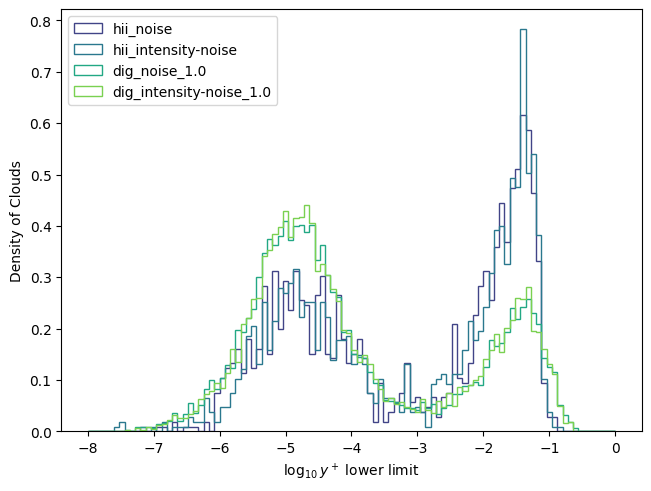

In [9]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots(layout="constrained")
bins = np.linspace(-8.0, 0.0, 101)

colors = cm.viridis(np.linspace(0.2, 0.8, len(datasets)))
for dataset, color in zip(datasets, colors):
  ax.hist(np.log10(data[dataset]["cloud_results"]["yplus_hdi_3%"]), histtype="step", color=color, bins=bins, density=True, label=dataset)
ax.legend(loc="best")
ax.set_xlabel(r"$\log_{10} y^+$ lower limit")
ax.set_ylabel("Density of Clouds")

In [10]:
# Inidicate limits
log10_yplus_lower_limit_threshold = -3.0
for dataset in datasets:
  data[dataset]["cloud_results"]["is_limit"] = np.log10(data[dataset]["cloud_results"]["yplus_hdi_3%"]) < log10_yplus_lower_limit_threshold

Text(0, 0.5, 'Density of Clouds')

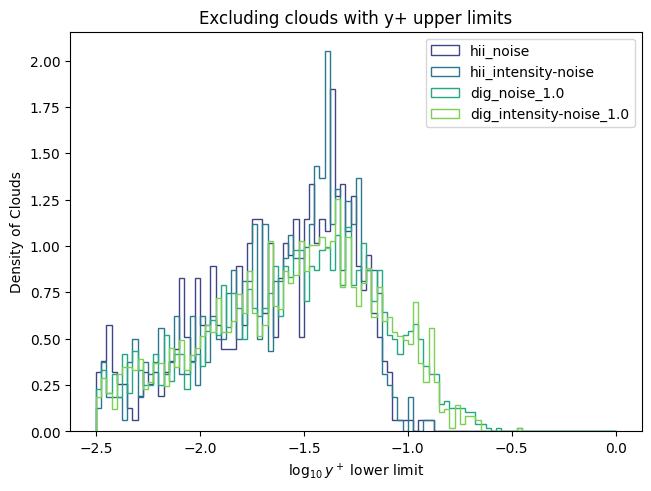

In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots(layout="constrained")
bins = np.linspace(-2.5, 0.0, 101)

colors = cm.viridis(np.linspace(0.2, 0.8, len(datasets)))
for dataset, color in zip(datasets, colors):
  mask = ~data[dataset]["cloud_results"]["is_limit"]
  ax.hist(np.log10(data[dataset]["cloud_results"].loc[mask, "yplus_hdi_3%"]), histtype="step", color=color, bins=bins, density=True, label=dataset)
ax.legend(loc="best")
ax.set_title("Excluding clouds with y+ upper limits")
ax.set_xlabel(r"$\log_{10} y^+$ lower limit")
ax.set_ylabel("Density of Clouds")

Text(0, 0.5, 'Density of Clouds')

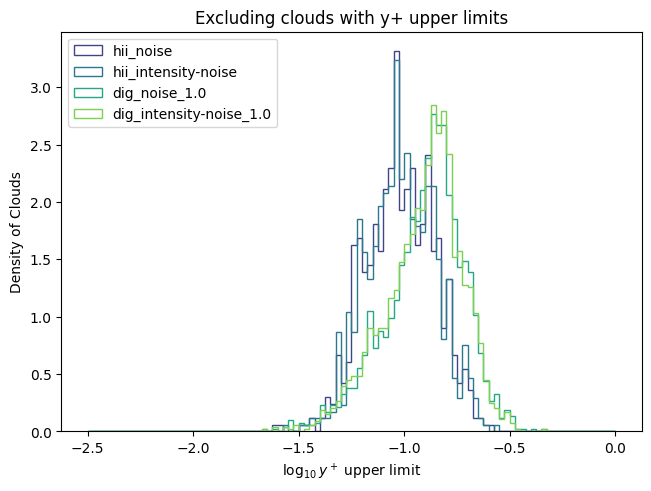

In [12]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots(layout="constrained")
bins = np.linspace(-2.5, 0.0, 101)

colors = cm.viridis(np.linspace(0.2, 0.8, len(datasets)))
for dataset, color in zip(datasets, colors):
  mask = ~data[dataset]["cloud_results"]["is_limit"]
  ax.hist(np.log10(data[dataset]["cloud_results"].loc[mask, "yplus_hdi_97%"]), histtype="step", color=color, bins=bins, density=True, label=dataset)
ax.legend(loc="best")
ax.set_title("Excluding clouds with y+ upper limits")
ax.set_xlabel(r"$\log_{10} y^+$ upper limit")
ax.set_ylabel("Density of Clouds")

## Plot HII Region Spectrum

551


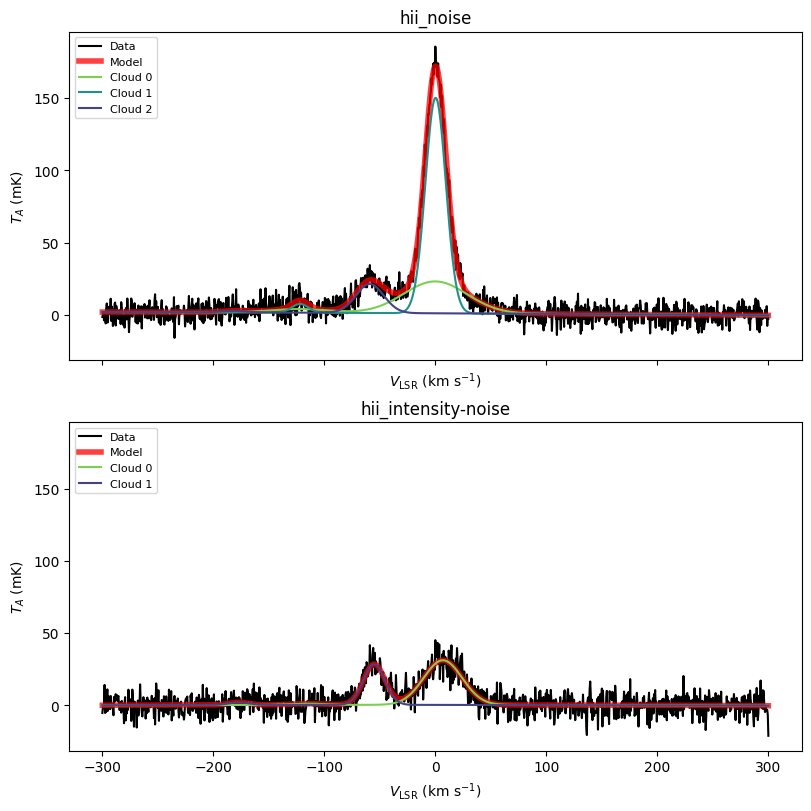

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# choose a sightline
# idx = 0

# choose a random sightline
# idx = np.random.choice(data["hii_noise"]["sightline_results"].index)

# choose a random sightline based on cloud parameter
sightline_idx = np.random.choice(
    data["hii_noise"]["cloud_results"].loc[
      ~data["hii_noise"]["cloud_results"]["is_limit"],
      "sightline_idx",
    ]
)
idx = data["hii_noise"]["sightline_results"].loc[
    data["hii_noise"]["sightline_results"]["sightline_idx"].eq(sightline_idx)
].index[0]

print(idx)

chan = np.linspace(-300.0, 300.0, 1201)
fig, axes = plt.subplots(2, layout="constrained", figsize=(8, 8), sharex=True, sharey=True)
for dataset, ax in zip(["hii_noise", "hii_intensity-noise"], axes.ravel()):
  sightline_data = data[dataset]["sightline_results"].iloc[idx]

  # data
  ax.plot(chan, sightline_data["spectrum"], "k-", label="Data", zorder=1)

  # combined model
  ax.plot(chan, sightline_data["model"], "r-", lw=4, alpha=0.75, label="Model", zorder=2)

  # loop over clouds
  n_clouds = sightline_data["best_n_gauss"]
  if n_clouds > 1:
    colors = cm.viridis(np.linspace(0.8, 0.2, n_clouds))
    for cloud, color in enumerate(colors):
      cloud_data = data[dataset]["cloud_results"].loc[
          (data[dataset]["cloud_results"]["sightline_idx"] == sightline_data["sightline_idx"]) &
          (data[dataset]["cloud_results"]["cloud"] == cloud)
      ].iloc[0]
      ax.plot(chan, cloud_data["model"], "-", color=color, label=f"Cloud {cloud}", zorder=3)

  ax.set_title(dataset)
  ax.set_xlabel(r"$V_{\rm LSR}$ (km s$^{-1}$)")
  ax.set_ylabel(r"$T_A$ (mK)")
  ax.legend(loc="upper left", fontsize=8)


## Plot DIG Spectrum

630


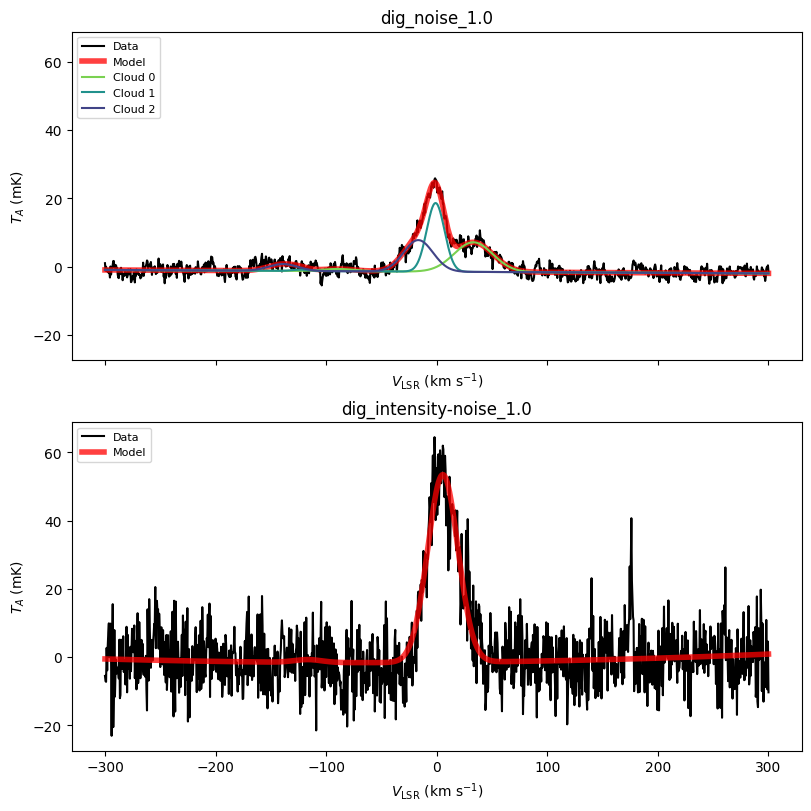

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# choose a sightline
# idx = 0

# choose a random sightline
# idx = np.random.choice(data["dig_noise_1.0"]["sightline_results"].index)

# choose a random sightline based on cloud parameter
sightline_idx = np.random.choice(
    data["dig_noise_1.0"]["cloud_results"].loc[
      #~data["dig_noise_1.0"]["cloud_results"]["is_limit"],
      data["dig_noise_1.0"]["cloud_results"]["yplus_mean"].gt(0.2),
      "sightline_idx",
    ]
)
idx = data["dig_noise_1.0"]["sightline_results"].loc[
    data["dig_noise_1.0"]["sightline_results"]["sightline_idx"].eq(sightline_idx)
].index[0]

print(idx)

chan = np.linspace(-300.0, 300.0, 1201)
fig, axes = plt.subplots(2, layout="constrained", figsize=(8, 8), sharex=True, sharey=True)
for dataset, ax in zip(["dig_noise_1.0", "dig_intensity-noise_1.0"], axes.ravel()):
  sightline_data = data[dataset]["sightline_results"].iloc[idx]

  # data
  ax.plot(chan, sightline_data["spectrum"], "k-", label="Data", zorder=1)

  # combined model
  ax.plot(chan, sightline_data["model"], "r-", lw=4, alpha=0.75, label="Model", zorder=2)

  # loop over clouds
  n_clouds = sightline_data["best_n_gauss"]
  if n_clouds > 1:
    colors = cm.viridis(np.linspace(0.8, 0.2, n_clouds))
    for cloud, color in enumerate(colors):
      cloud_data = data[dataset]["cloud_results"].loc[
          (data[dataset]["cloud_results"]["sightline_idx"] == sightline_data["sightline_idx"]) &
          (data[dataset]["cloud_results"]["cloud"] == cloud)
      ].iloc[0]
      ax.plot(chan, cloud_data["model"], "-", color=color, label=f"Cloud {cloud}", zorder=3)

  ax.set_title(dataset)
  ax.set_xlabel(r"$V_{\rm LSR}$ (km s$^{-1}$)")
  ax.set_ylabel(r"$T_A$ (mK)")
  ax.legend(loc="upper left", fontsize=8)


## Number of Gaussian Components

Text(0.02, 0.5, 'Number of Sightlines')

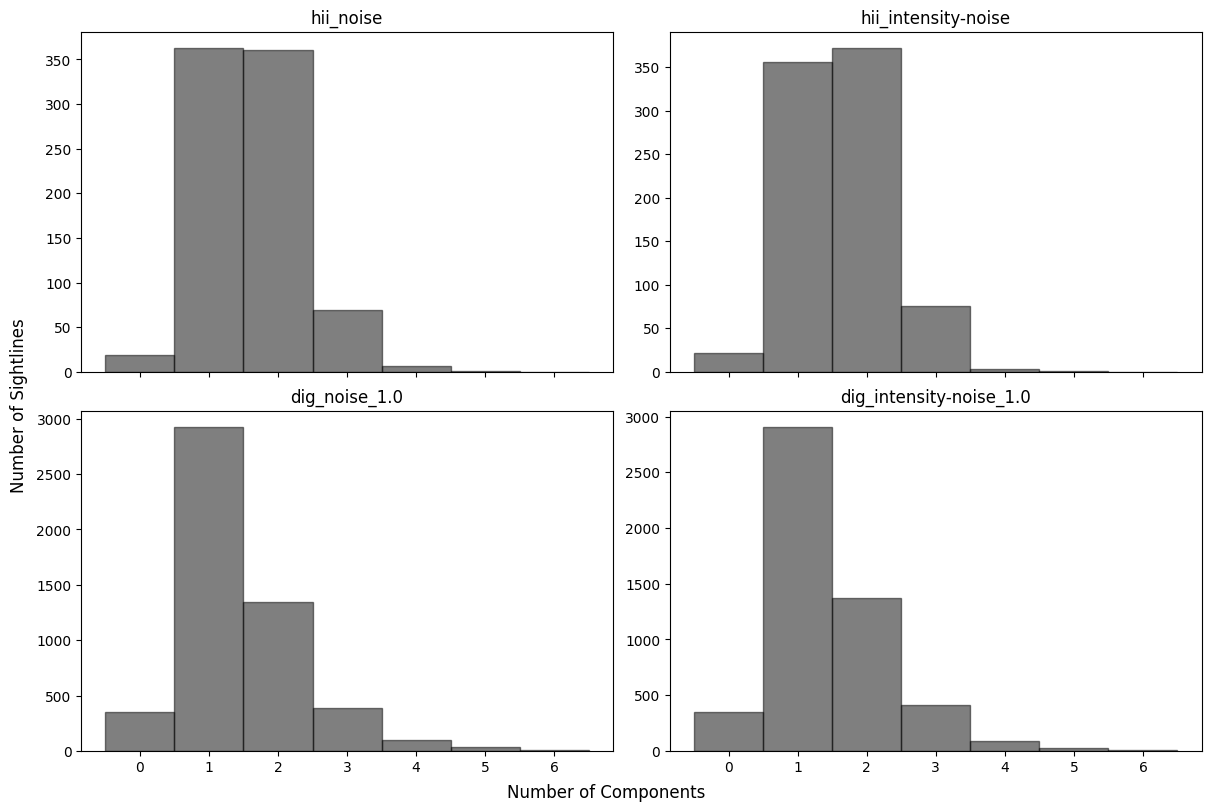

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True)
for dataset, ax in zip(datasets, axes.ravel()):
  ax.hist(data[dataset]["sightline_results"]["best_n_gauss"], bins=np.arange(8)-0.5, color="k", edgecolor="k", alpha=0.5)
  ax.set_title(dataset)
fig.supxlabel("Number of Components")
fig.supylabel("Number of Sightlines")

## y+ vs. SNR

Text(0.02, 0.5, 'Number of Clouds')

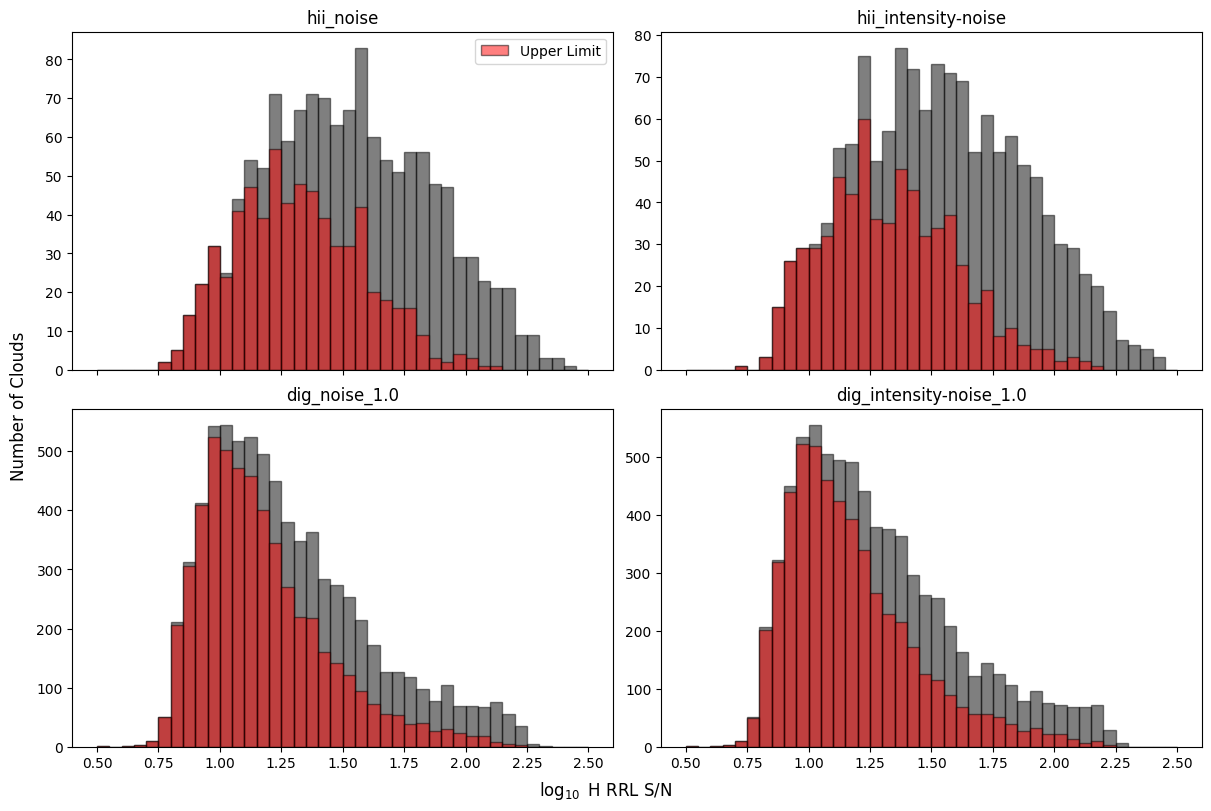

In [36]:
fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True)
bins = np.linspace(0.5, 2.5, 41)
for dataset, ax in zip(datasets, axes.ravel()):
  ax.hist(np.log10(data[dataset]["cloud_results"]["H SNR"]), bins=bins, color="k", edgecolor="k", alpha=0.5)
  ax.hist(np.log10(data[dataset]["cloud_results"].loc[data[dataset]["cloud_results"]["is_limit"], "H SNR"]), bins=bins, color="r", edgecolor="k", alpha=0.5, label="Upper Limit")
  ax.set_title(dataset)
axes[0, 0].legend(loc="best")
fig.supxlabel(r"$\log_{10}$ H RRL S/N")
fig.supylabel("Number of Clouds")

Text(0.02, 0.5, 'Number of Clouds')

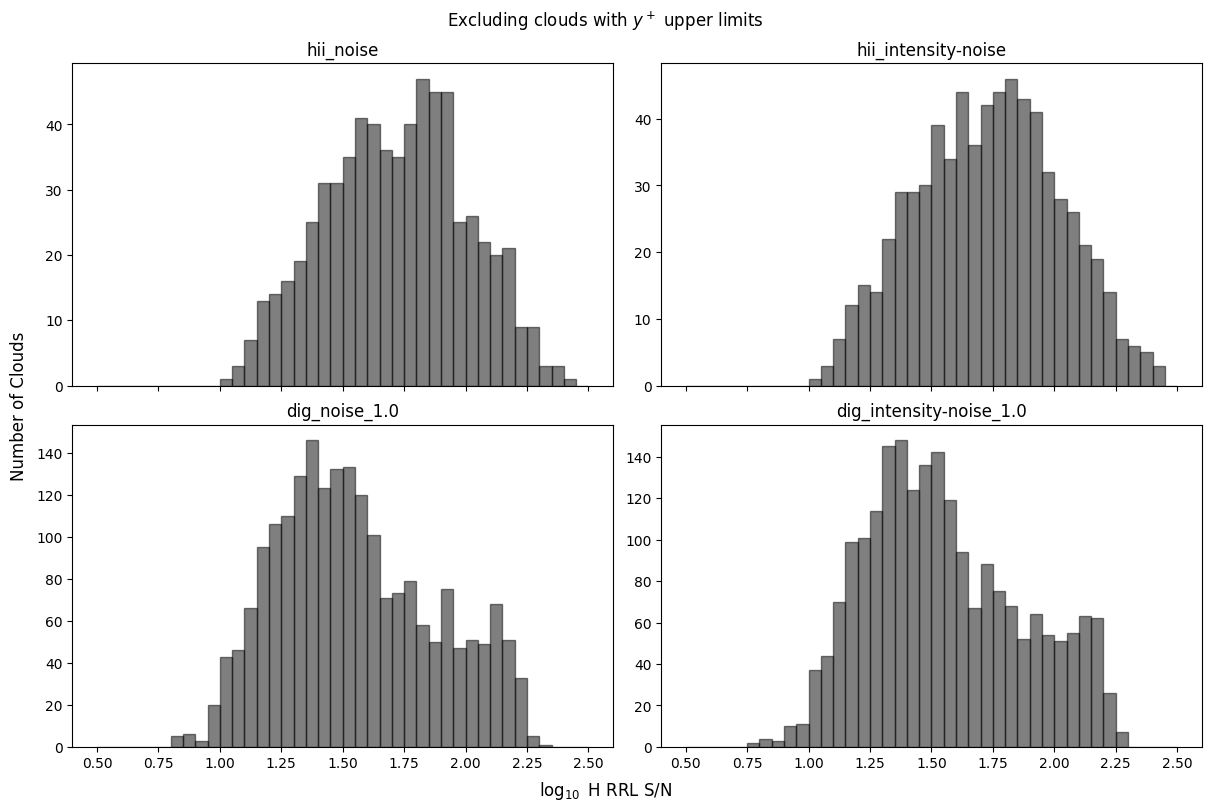

In [38]:
fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True)
bins = np.linspace(0.5, 2.5, 41)
for dataset, ax in zip(datasets, axes.ravel()):
  ax.hist(np.log10(data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "H SNR"]), bins=bins, color="k", edgecolor="k", alpha=0.5)
  ax.set_title(dataset)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"$\log_{10}$ H RRL S/N")
fig.supylabel("Number of Clouds")

Text(0.02, 0.5, 'Number of Clouds')

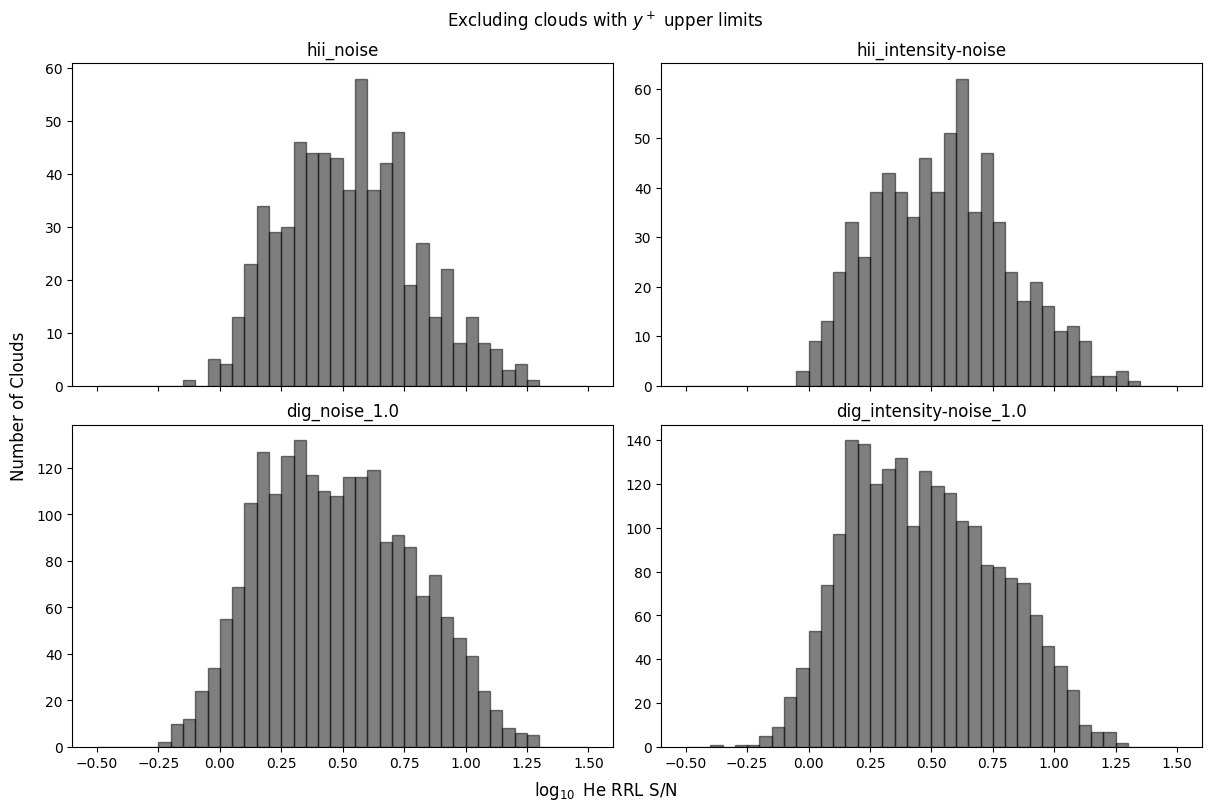

In [41]:
fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True)
bins = np.linspace(-0.5, 1.5, 41)
for dataset, ax in zip(datasets, axes.ravel()):
  ax.hist(np.log10(data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "He SNR"]), bins=bins, color="k", edgecolor="k", alpha=0.5)
  ax.set_title(dataset)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"$\log_{10}$ He RRL S/N")
fig.supylabel("Number of Clouds")

Text(0.02, 0.5, '$\\log_{10}$ He RRL S/N')

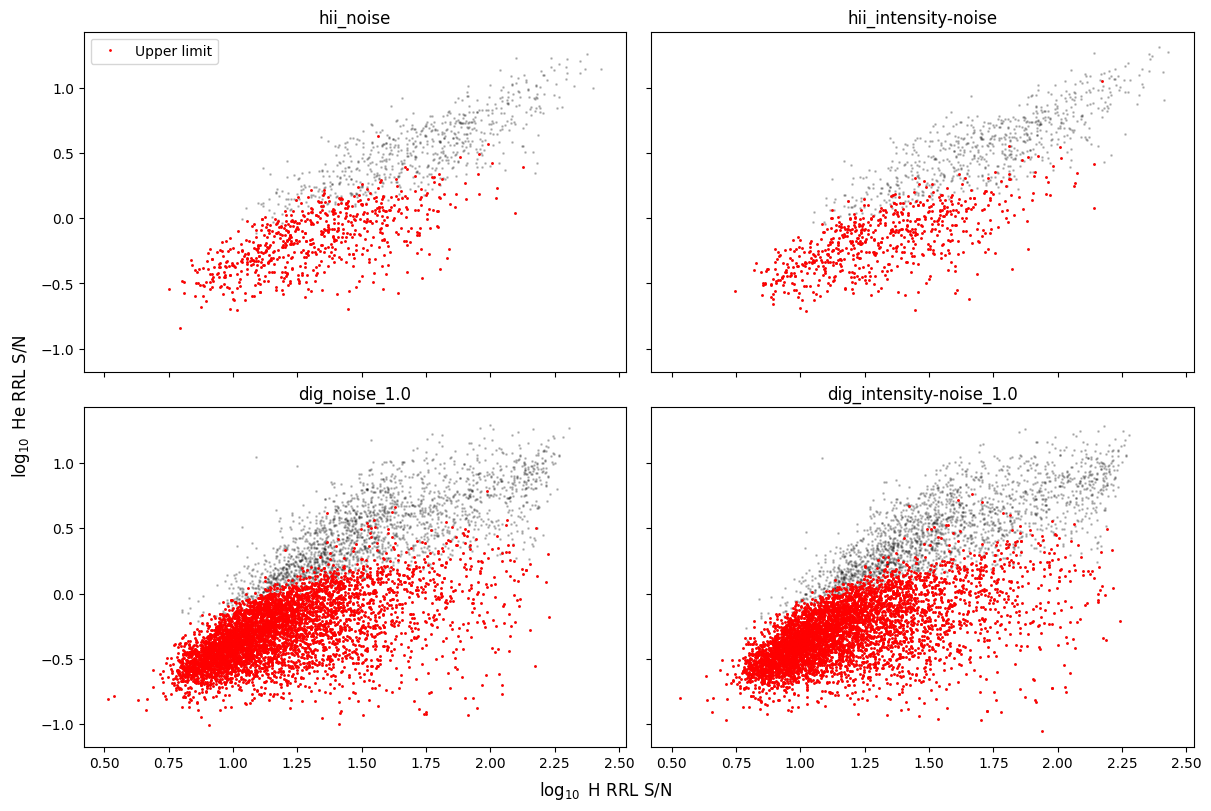

In [93]:
fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for dataset, ax in zip(datasets, axes.ravel()):
  ax.plot(
      np.log10(data[dataset]["cloud_results"]["H SNR"]),
      np.log10(data[dataset]["cloud_results"]["He SNR"]),
      "ko",
      alpha=0.2,
      markersize=1,
  )
  ax.plot(
      np.log10(data[dataset]["cloud_results"].loc[data[dataset]["cloud_results"]["is_limit"], "H SNR"]),
      np.log10(data[dataset]["cloud_results"].loc[data[dataset]["cloud_results"]["is_limit"], "He SNR"]),
      "ro",
      label="Upper limit",
      alpha=1.0,
      markersize=1,
  )
  ax.set_title(dataset)
axes[0, 0].legend(loc="best")
fig.supxlabel(r"$\log_{10}$ H RRL S/N")
fig.supylabel(r"$\log_{10}$ He RRL S/N")

Text(0.02, 0.5, '$\\log_{10}$ He RRL S/N')

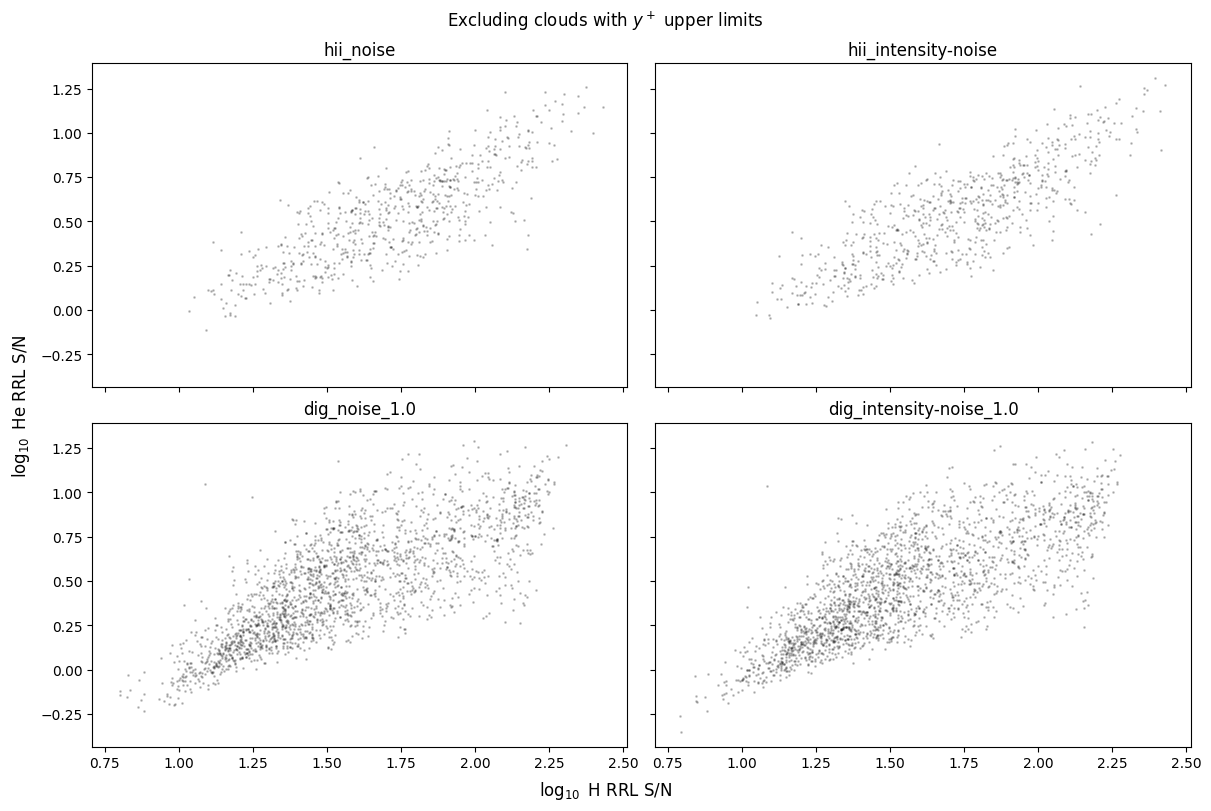

In [43]:
fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for dataset, ax in zip(datasets, axes.ravel()):
  ax.plot(
      np.log10(data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "H SNR"]),
      np.log10(data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "He SNR"]),
      "ko",
      alpha=0.2,
      markersize=1,
  )
  ax.set_title(dataset)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"$\log_{10}$ H RRL S/N")
fig.supylabel(r"$\log_{10}$ He RRL S/N")

Text(0.02, 0.5, 'Number of Clouds')

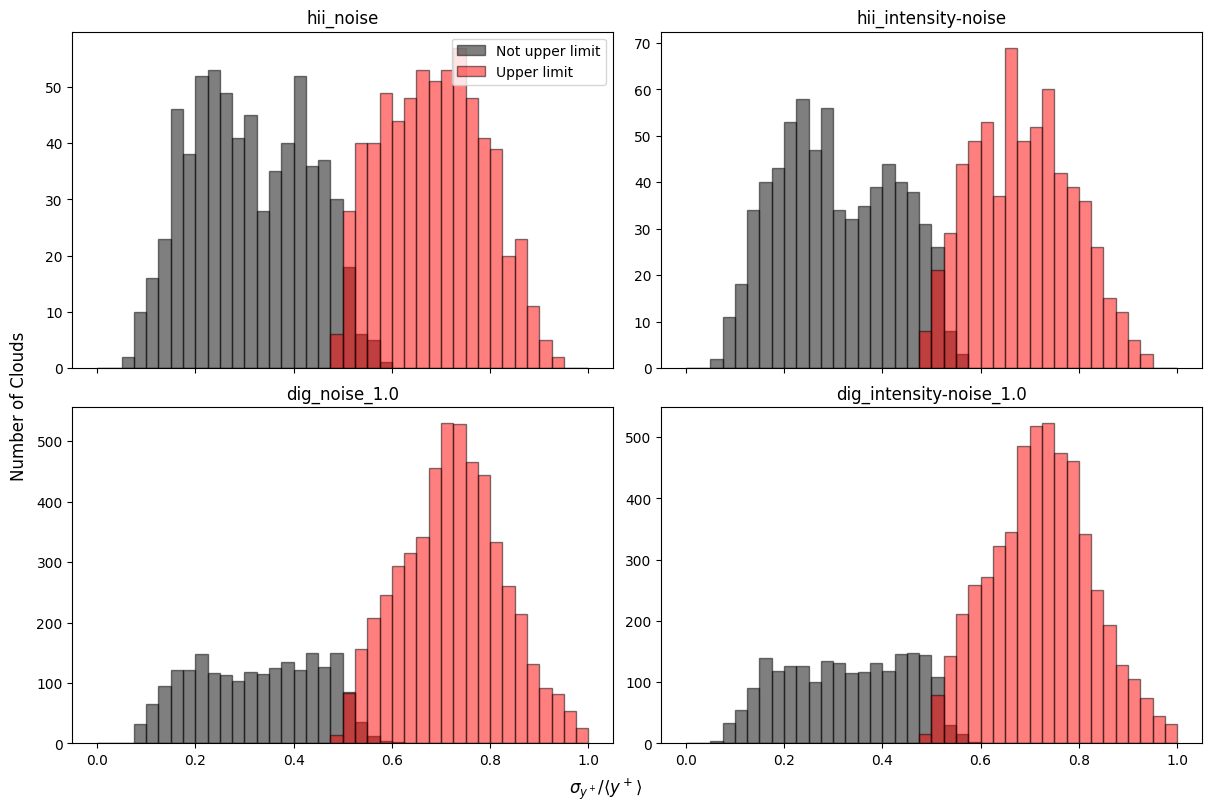

In [83]:
fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True)
bins=np.linspace(0.0, 1.0, 41)
for dataset, ax in zip(datasets, axes.ravel()):
  ax.hist(
      (data[dataset]["cloud_results"]["yplus_sd"]/data[dataset]["cloud_results"]["yplus_mean"]).loc[~data[dataset]["cloud_results"]["is_limit"]],
      bins=bins,
      alpha=0.5,
      color="k",
      label="Not upper limit",
      edgecolor="k",
  )
  ax.hist(
      (data[dataset]["cloud_results"]["yplus_sd"]/data[dataset]["cloud_results"]["yplus_mean"]).loc[data[dataset]["cloud_results"]["is_limit"]],
      bins=bins,
      alpha=0.5,
      color="r",
      label="Upper limit",
      edgecolor="k",
  )
  ax.set_title(dataset)
axes[0, 0].legend(loc="best")
fig.supxlabel(r"$\sigma_{y^+}/\langle y^+\rangle$")
fig.supylabel(r"Number of Clouds")

Text(0.02, 0.5, 'Number of Clouds')

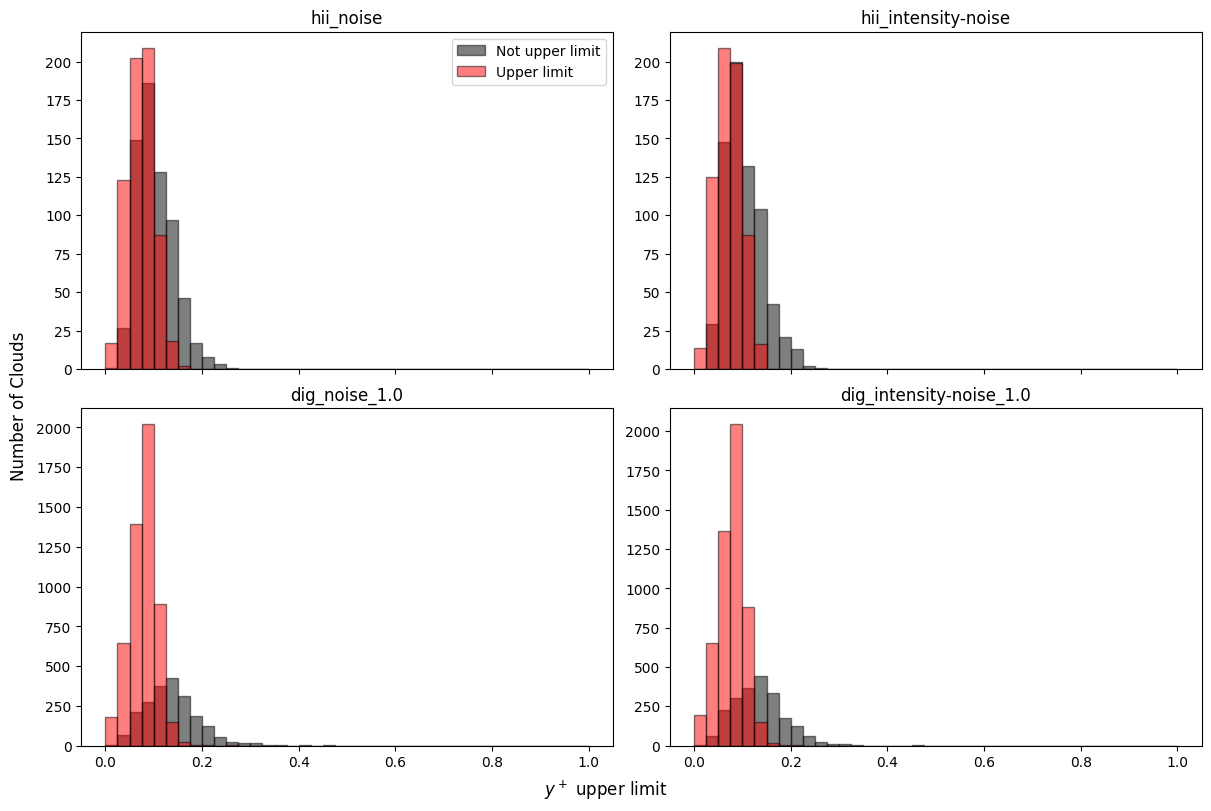

In [88]:
fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True)
bins=np.linspace(0.0, 1.0, 41)
for dataset, ax in zip(datasets, axes.ravel()):
  ax.hist(
      data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "yplus_hdi_97%"],
      bins=bins,
      alpha=0.5,
      color="k",
      label="Not upper limit",
      edgecolor="k",
  )
  ax.hist(
      data[dataset]["cloud_results"].loc[data[dataset]["cloud_results"]["is_limit"], "yplus_hdi_97%"],
      bins=bins,
      alpha=0.5,
      color="r",
      label="Upper limit",
      edgecolor="k",
  )
  ax.set_title(dataset)
axes[0, 0].legend(loc="best")
fig.supxlabel(r"$y^+$ upper limit")
fig.supylabel(r"Number of Clouds")

Text(0.02, 0.5, '$y^+$')

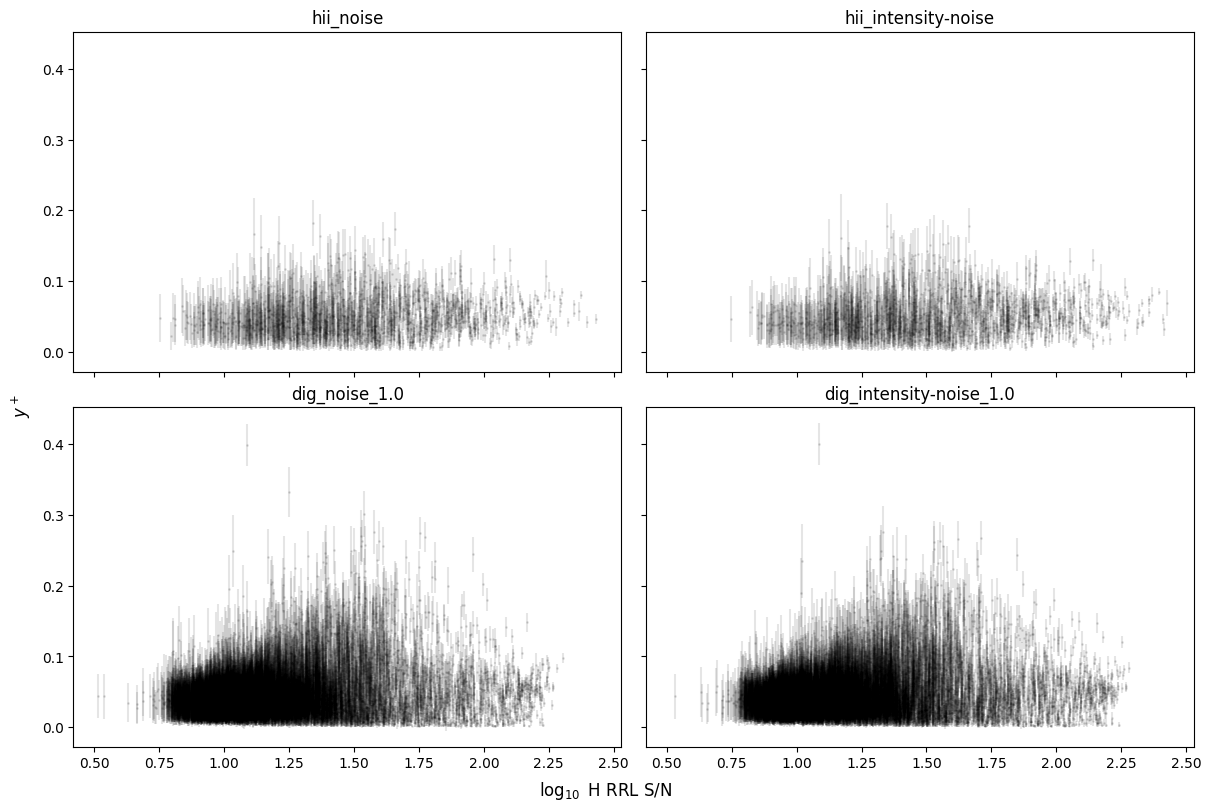

In [15]:
fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for dataset, ax in zip(datasets, axes.ravel()):
  ax.errorbar(
      np.log10(data[dataset]["cloud_results"]["H SNR"]),
      data[dataset]["cloud_results"]["yplus_mean"],
      #yerr=[
      #    data[dataset]["cloud_results"]["yplus_mean"] - data[dataset]["cloud_results"]["yplus_hdi_3%"],
      #    data[dataset]["cloud_results"]["yplus_hdi_97%"] - data[dataset]["cloud_results"]["yplus_mean"]
      #],
      yerr=data[dataset]["cloud_results"]["yplus_sd"],
      linestyle="none",
      marker='o',
      color='k',
      alpha=0.1,
      markersize=1,
  )
  ax.set_title(dataset)
fig.supxlabel(r"$\log_{10}$ H RRL S/N")
fig.supylabel(r"$y^+$")

Text(0.02, 0.5, '$y^+$')

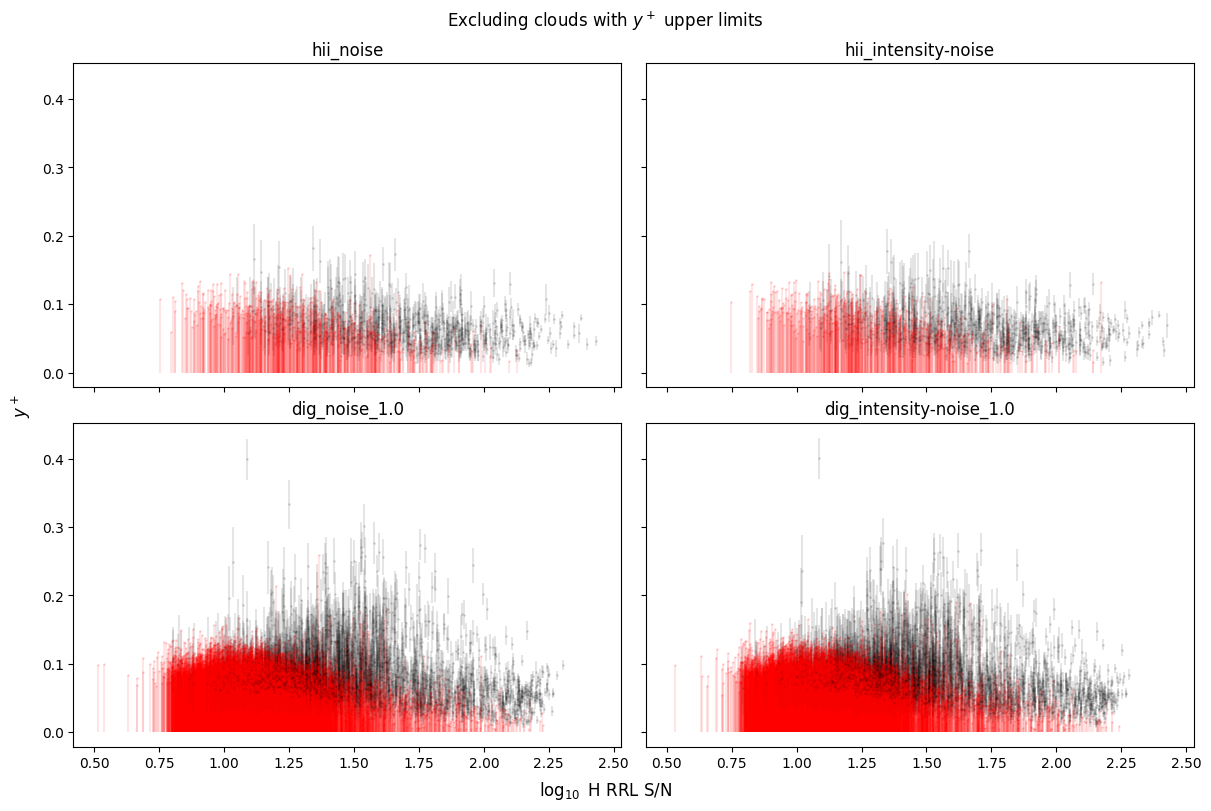

In [91]:
fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for dataset, ax in zip(datasets, axes.ravel()):
  ax.errorbar(
      np.log10(data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "H SNR"]),
      data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "yplus_mean"],
      #yerr=[
      #    data[dataset]["cloud_results"]["yplus_mean"] - data[dataset]["cloud_results"]["yplus_hdi_3%"],
      #    data[dataset]["cloud_results"]["yplus_hdi_97%"] - data[dataset]["cloud_results"]["yplus_mean"]
      #],
      yerr=data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "yplus_sd"],
      linestyle="none",
      marker='o',
      color='k',
      alpha=0.1,
      markersize=1,
  )
  ax.errorbar(
      np.log10(data[dataset]["cloud_results"].loc[data[dataset]["cloud_results"]["is_limit"], "H SNR"]),
      data[dataset]["cloud_results"].loc[data[dataset]["cloud_results"]["is_limit"], "yplus_hdi_97%"],
      yerr=[
          data[dataset]["cloud_results"].loc[data[dataset]["cloud_results"]["is_limit"], "yplus_hdi_97%"],
          np.zeros(data[dataset]["cloud_results"]["is_limit"].sum()),
      ],
      linestyle="none",
      marker='o',
      color='r',
      alpha=0.1,
      markersize=1,
  )
  ax.set_title(dataset)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"$\log_{10}$ H RRL S/N")
fig.supylabel(r"$y^+$")

Text(0.02, 0.5, '$y^+$')

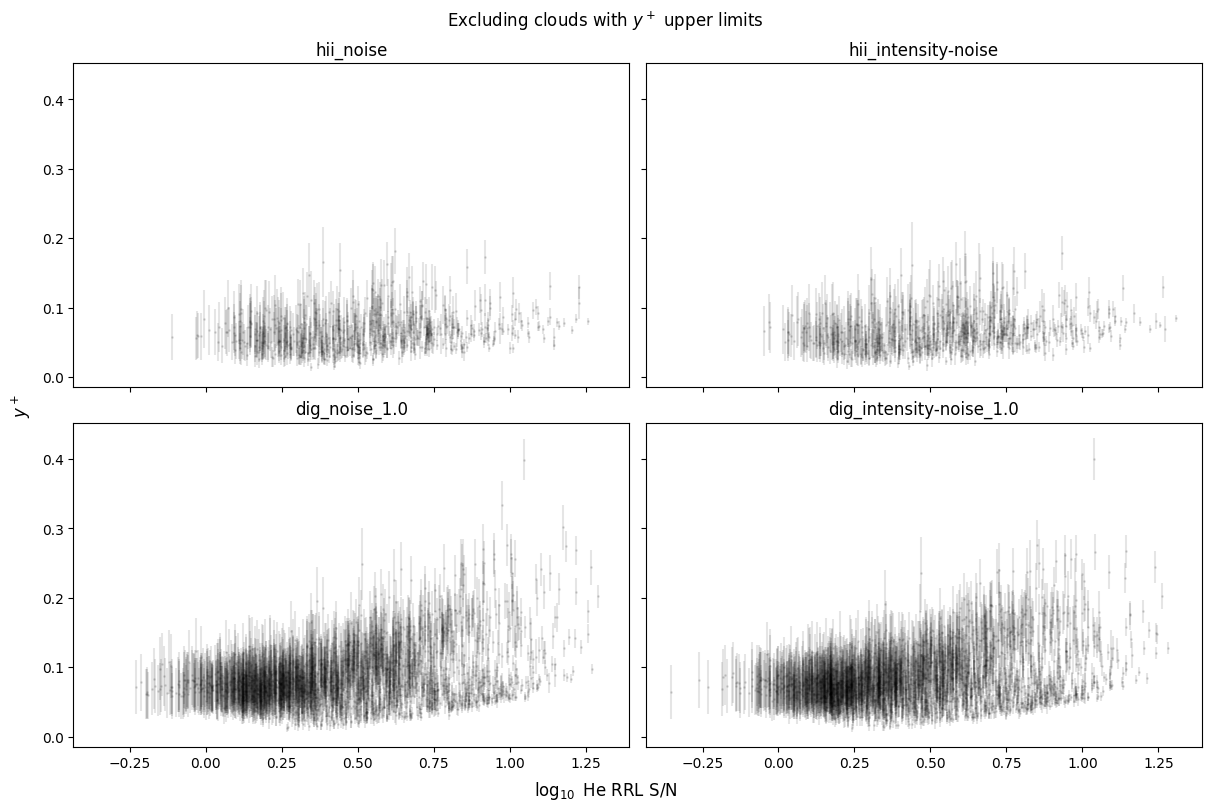

In [47]:
fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for dataset, ax in zip(datasets, axes.ravel()):
  ax.errorbar(
      np.log10(data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "He SNR"]),
      data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "yplus_mean"],
      #yerr=[
      #    data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "yplus_mean"] - data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "yplus_hdi_3%"],
      #    data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "yplus_hdi_97%"] - data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "yplus_mean"]
      #],
      yerr=data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "yplus_sd"],
      linestyle="none",
      marker='o',
      color='k',
      alpha=0.1,
      markersize=1,
  )
  ax.set_title(dataset)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"$\log_{10}$ He RRL S/N")
fig.supylabel(r"$y^+$")

## y+ PDFs vs SNR

In [48]:
# construct prior PDF
from scipy.stats import halfnorm

sigma = 0.05
yplus_prior = halfnorm(scale=sigma)
yplus_prior_x = np.linspace(
    yplus_prior.ppf(1.0e-3),
    yplus_prior.ppf(1.0-1.0e-3),
    1000,
)
yplus_prior_pdf = yplus_prior.pdf(yplus_prior_x)

Text(0.02, 0.5, 'Density of Clouds')

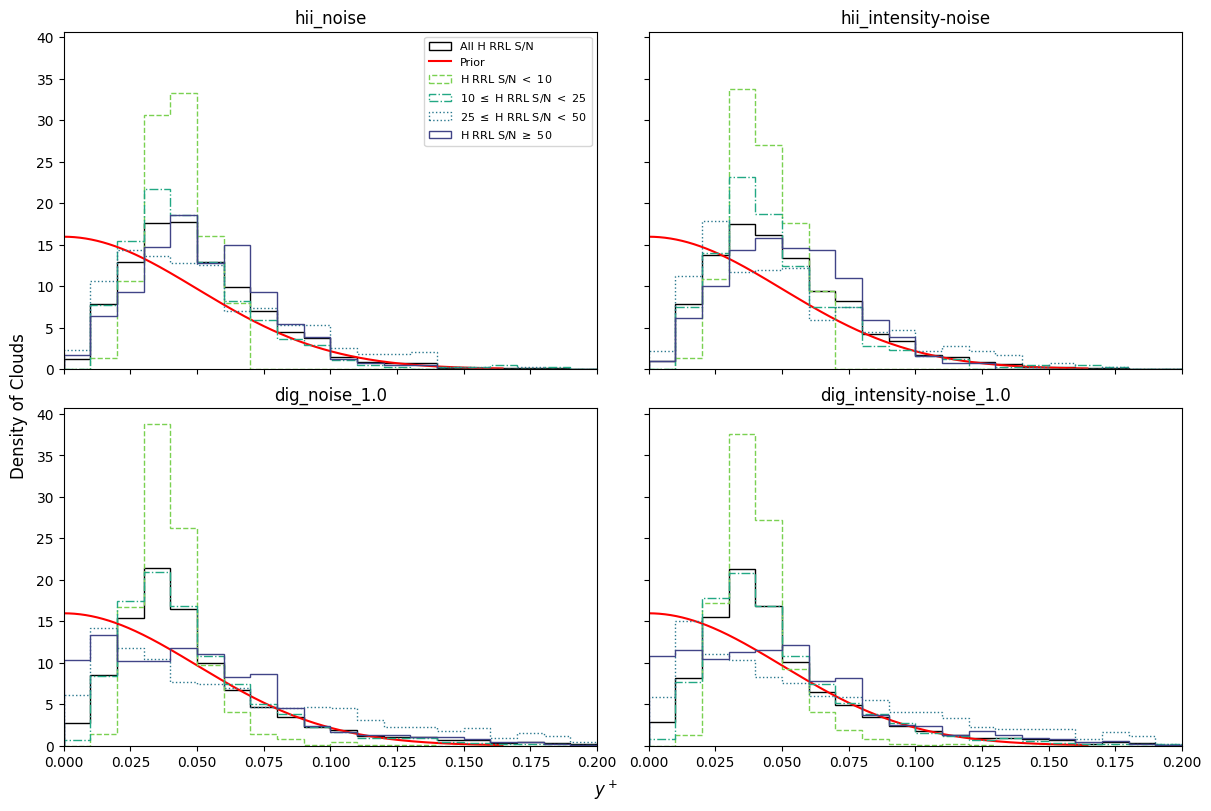

In [50]:
from itertools import cycle
linestyles = ["--", "-.", ":", "-"]

# histogram with SNR thresholds
snr_thresholds = {
    "no_signal": [0.0, 10.0],
    "low_snr": [10.0, 25.0],
    "mid_snr": [25.0, 50.0],
    "high_snr": [50.0, np.inf],
}
colors = cm.viridis(np.linspace(0.8, 0.2, len(snr_thresholds)))

bins = np.arange(0.0, 0.31, 0.01)
fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for dataset, ax in zip(datasets, axes.ravel()):
  # plot PDF
  ax.hist(
      data[dataset]["cloud_results"]["yplus_mean"],
      bins=bins,
      label="All H RRL S/N",
      histtype="step",
      density=True,
      linestyle="-",
      lw=2,
      edgecolor="k",
  )

  # plot prior
  ax.plot(yplus_prior_x, yplus_prior_pdf, "r-", label="Prior")

  # breakdown by SNR threshold
  cycle_linestyles = cycle(linestyles)
  for (snr, limits), color in zip(snr_thresholds.items(), colors):
    mask = (data[dataset]["cloud_results"]["H SNR"] >= limits[0]) & (
        data[dataset]["cloud_results"]["H SNR"] < limits[1]
    )
    if limits[0] == 0:
      label = r"H RRL S/N $<$ "+f"{int(limits[1])}"
    elif np.isinf(limits[1]):
      label = r"H RRL S/N $\geq$ "+f"{int(limits[0])}"
    else:
      label = f"{int(limits[0])}"+r" $\leq$ H RRL S/N $<$ "+f"{int(limits[1])}"
    ax.hist(
        data[dataset]["cloud_results"].loc[mask, "yplus_mean"],
        bins=bins,
        label=label,
        histtype="step",
        density=True,
        linestyle=next(cycle_linestyles),
        lw=1,
        color=color,
    )
  ax.set_title(dataset)
axes[0, 0].legend(loc="upper right", fontsize=8)
axes[0, 0].set_xlim(0.0, 0.2)
fig.supxlabel(r"$y^+$")
fig.supylabel("Density of Clouds")

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Text(0.02, 0.5, 'Density of Clouds')

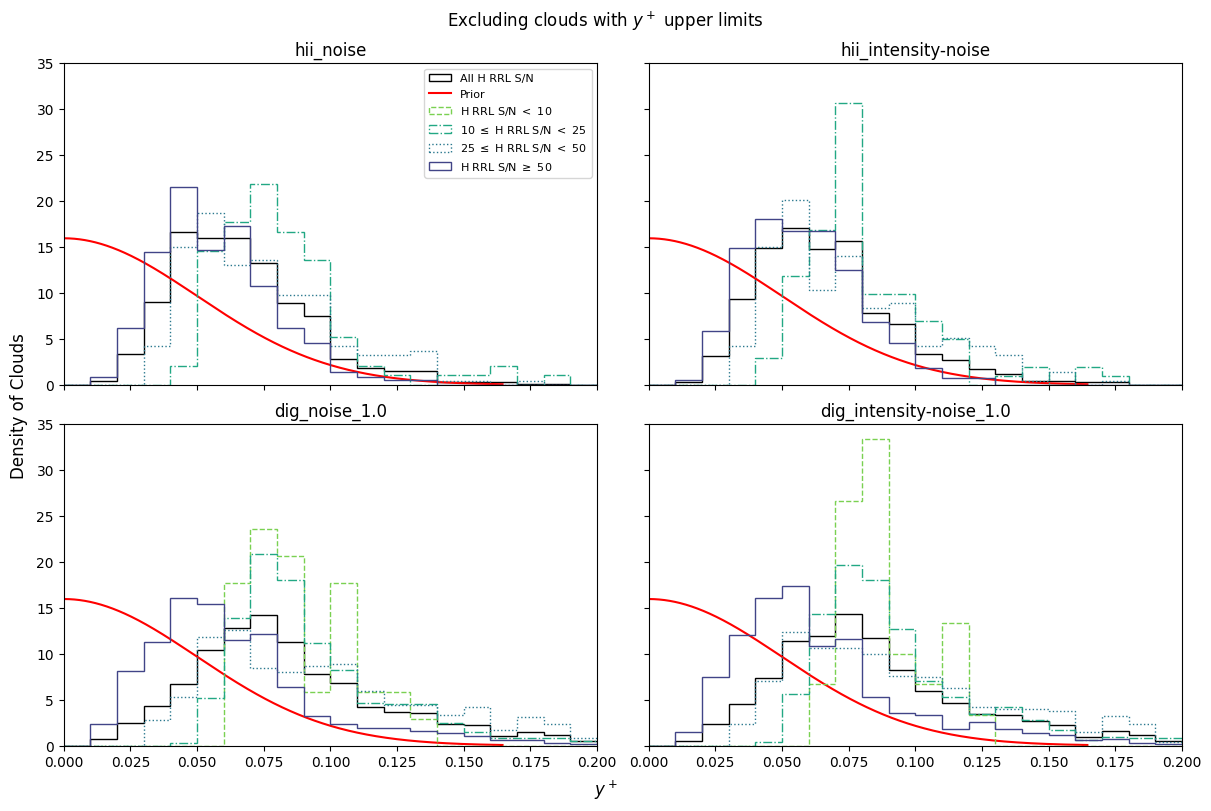

In [51]:
from itertools import cycle
linestyles = ["--", "-.", ":", "-"]

# histogram with SNR thresholds
snr_thresholds = {
    "no_signal": [0.0, 10.0],
    "low_snr": [10.0, 25.0],
    "mid_snr": [25.0, 50.0],
    "high_snr": [50.0, np.inf],
}
colors = cm.viridis(np.linspace(0.8, 0.2, len(snr_thresholds)))

bins = np.arange(0.0, 0.31, 0.01)
fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for dataset, ax in zip(datasets, axes.ravel()):
  # plot PDF
  ax.hist(
      data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "yplus_mean"],
      bins=bins,
      label="All H RRL S/N",
      histtype="step",
      density=True,
      linestyle="-",
      lw=2,
      edgecolor="k",
  )

  # plot prior
  ax.plot(yplus_prior_x, yplus_prior_pdf, "r-", label="Prior")

  # breakdown by SNR threshold
  cycle_linestyles = cycle(linestyles)
  for (snr, limits), color in zip(snr_thresholds.items(), colors):
    mask = (data[dataset]["cloud_results"]["H SNR"] >= limits[0]) & (
        data[dataset]["cloud_results"]["H SNR"] < limits[1]
    ) & ~data[dataset]["cloud_results"]["is_limit"]
    if limits[0] == 0:
      label = r"H RRL S/N $<$ "+f"{int(limits[1])}"
    elif np.isinf(limits[1]):
      label = r"H RRL S/N $\geq$ "+f"{int(limits[0])}"
    else:
      label = f"{int(limits[0])}"+r" $\leq$ H RRL S/N $<$ "+f"{int(limits[1])}"
    ax.hist(
        data[dataset]["cloud_results"].loc[mask, "yplus_mean"],
        bins=bins,
        label=label,
        histtype="step",
        density=True,
        linestyle=next(cycle_linestyles),
        lw=1,
        color=color,
    )
  ax.set_title(dataset)
axes[0, 0].legend(loc="upper right", fontsize=8)
axes[0, 0].set_xlim(0.0, 0.2)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"$y^+$")
fig.supylabel("Density of Clouds")

## y+ CDFs vs SNR

In [52]:
# Generate prior mean CDF samples
n_samples = 10000
yplus_prior_samples = yplus_prior.rvs(n_samples)
sort_idx = np.argsort(yplus_prior_samples)

H_area_prior = halfnorm(scale=1000.0)
H_area_prior_samples = H_area_prior.rvs(n_samples)
H_area_prior_samples /= H_area_prior_samples.sum()

yplus_prior_cdf = yplus_prior_samples[sort_idx]
H_area_prior_cdf = np.cumsum(H_area_prior_samples[sort_idx])

Text(0.02, 0.5, 'Cumulative Density of Clouds')

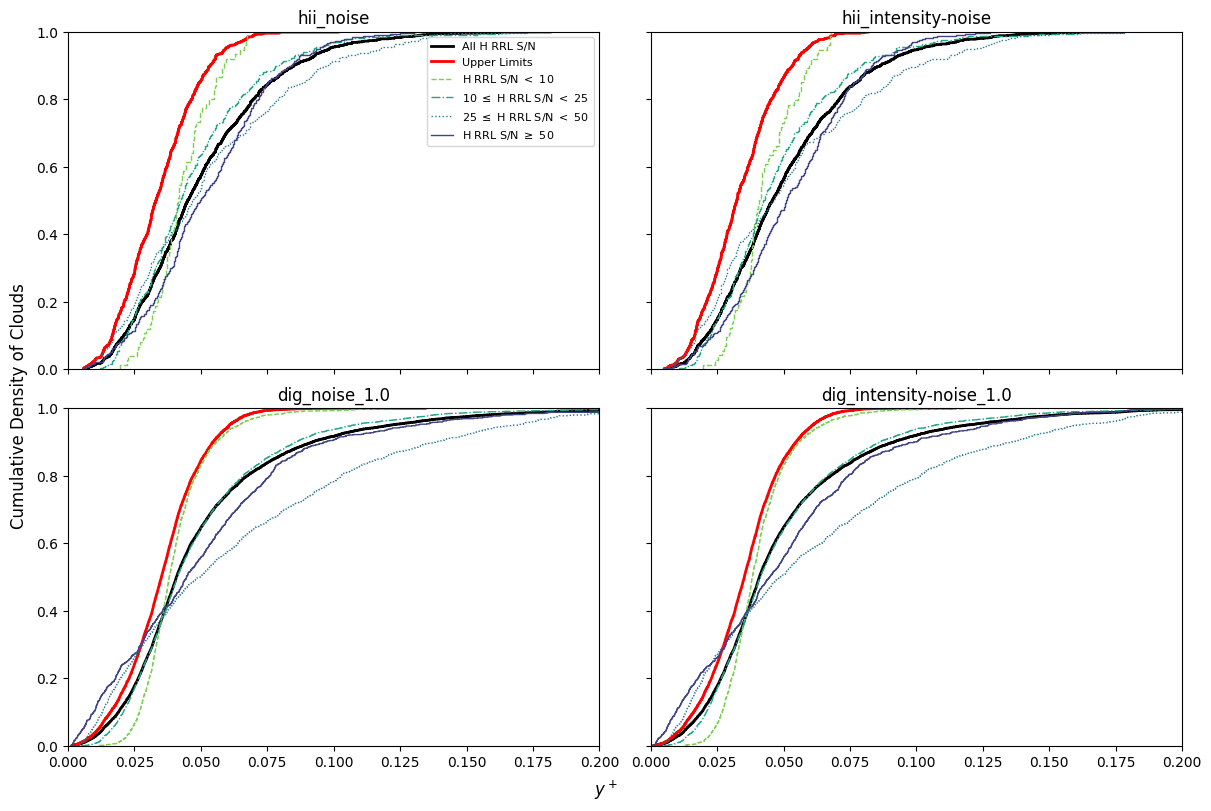

In [76]:
colors = cm.viridis(np.linspace(0.8, 0.2, len(snr_thresholds)))

fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for dataset, ax in zip(datasets, axes.ravel()):
  # plot CDF
  ax.ecdf(
      data[dataset]["cloud_results"]["yplus_mean"],
      label="All H RRL S/N",
      linestyle="-",
      lw=2,
      color="k",
  )

  # plot upper limit
  ax.ecdf(
      data[dataset]["cloud_results"].loc[data[dataset]["cloud_results"]["is_limit"], "yplus_mean"],
      label="Upper Limits",
      linestyle="-",
      lw=2,
      color="r",
  )

  # breakdown by SNR threshold
  cycle_linestyles = cycle(linestyles)
  for (snr, limits), color in zip(snr_thresholds.items(), colors):
    mask = (data[dataset]["cloud_results"]["H SNR"] >= limits[0]) & (
        data[dataset]["cloud_results"]["H SNR"] < limits[1]
    )
    if limits[0] == 0:
      label = r"H RRL S/N $<$ "+f"{int(limits[1])}"
    elif np.isinf(limits[1]):
      label = r"H RRL S/N $\geq$ "+f"{int(limits[0])}"
    else:
      label = f"{int(limits[0])}"+r" $\leq$ H RRL S/N $<$ "+f"{int(limits[1])}"
    ax.ecdf(
        data[dataset]["cloud_results"].loc[mask, "yplus_mean"],
        label=label,
        linestyle=next(cycle_linestyles),
        lw=1,
        color=color,
    )
  ax.set_title(dataset)
axes[0, 0].legend(loc="upper right", fontsize=8)
axes[0, 0].set_xlim(0.0, 0.2)
fig.supxlabel(r"$y^+$")
fig.supylabel("Cumulative Density of Clouds")

Text(0.02, 0.5, 'Cumulative Density of Clouds')

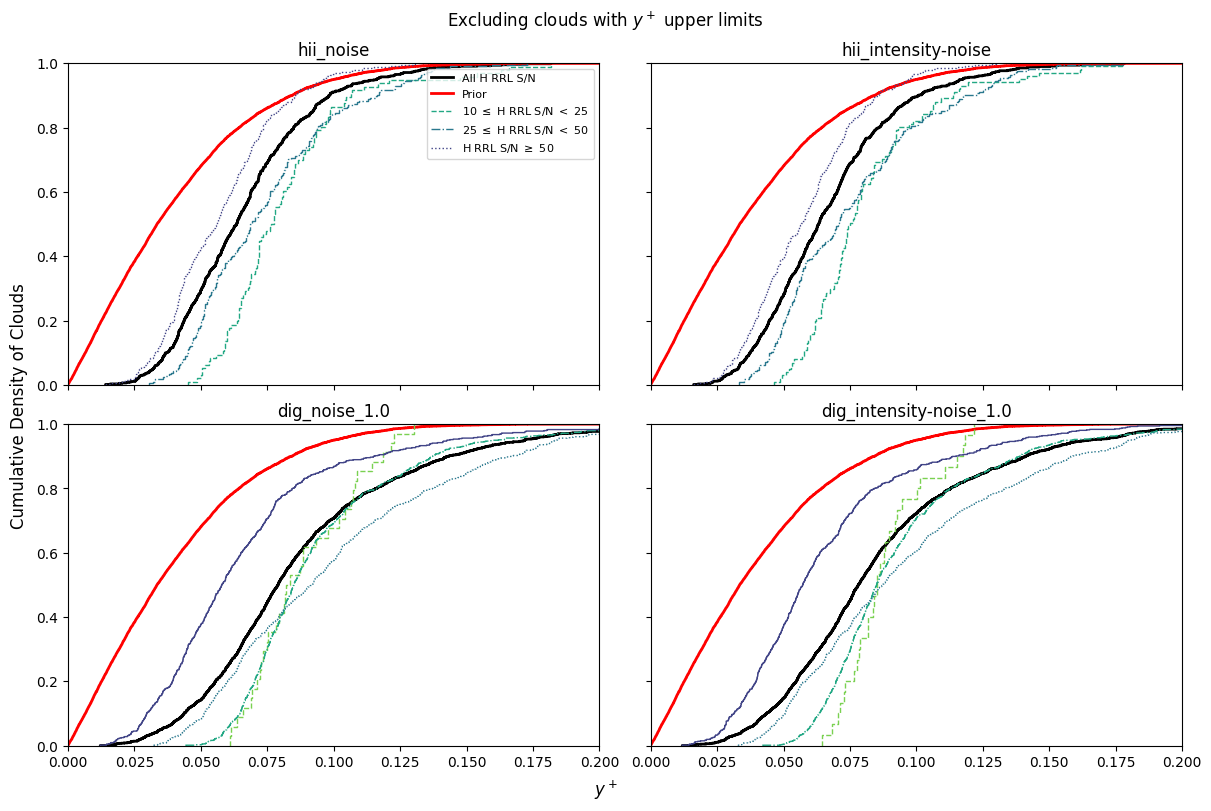

In [56]:
colors = cm.viridis(np.linspace(0.8, 0.2, len(snr_thresholds)))

fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for dataset, ax in zip(datasets, axes.ravel()):
  # plot CDF
  ax.ecdf(
      data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "yplus_mean"],
      label="All H RRL S/N",
      linestyle="-",
      lw=2,
      color="k",
  )

  # plot prior
  ax.ecdf(yplus_prior_samples, label="Prior", linestyle="-", lw=2, color="r")

  # breakdown by SNR threshold
  cycle_linestyles = cycle(linestyles)
  for (snr, limits), color in zip(snr_thresholds.items(), colors):
    mask = (data[dataset]["cloud_results"]["H SNR"] >= limits[0]) & (
        data[dataset]["cloud_results"]["H SNR"] < limits[1]
    ) & ~data[dataset]["cloud_results"]["is_limit"]
    if limits[0] == 0:
      label = r"H RRL S/N $<$ "+f"{int(limits[1])}"
    elif np.isinf(limits[1]):
      label = r"H RRL S/N $\geq$ "+f"{int(limits[0])}"
    else:
      label = f"{int(limits[0])}"+r" $\leq$ H RRL S/N $<$ "+f"{int(limits[1])}"
    if mask.sum() == 0:
      continue
    ax.ecdf(
        data[dataset]["cloud_results"].loc[mask, "yplus_mean"],
        label=label,
        linestyle=next(cycle_linestyles),
        lw=1,
        color=color,
    )
  ax.set_title(dataset)
axes[0, 0].legend(loc="upper right", fontsize=8)
axes[0, 0].set_xlim(0.0, 0.2)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"$y^+$")
fig.supylabel("Cumulative Density of Clouds")

Text(0.02, 0.5, 'Cumulative Normalized H RRL Area of Clouds')

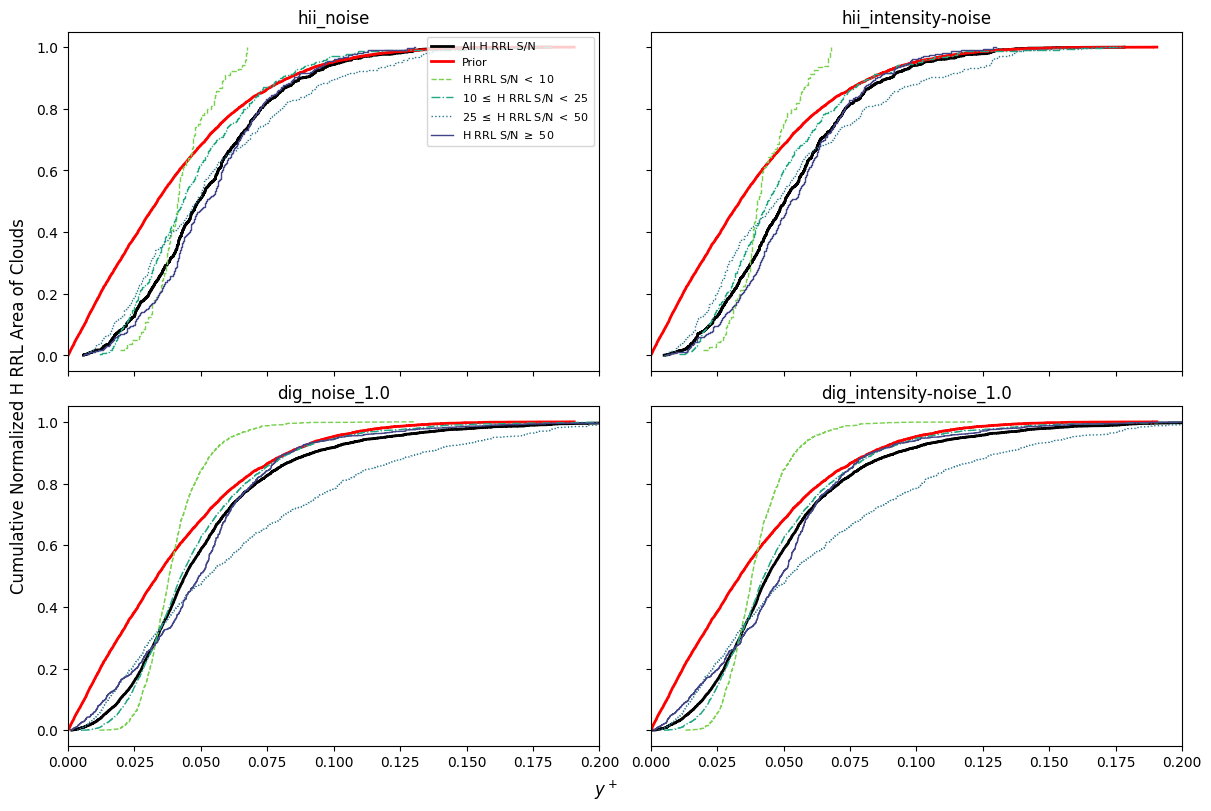

In [ ]:
colors = cm.viridis(np.linspace(0.8, 0.2, len(snr_thresholds)))

fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for dataset, ax in zip(datasets, axes.ravel()):
  # plot CDF vs H_area
  sort_idx = data[dataset]["cloud_results"]["yplus_mean"].argsort()
  yplus_cdf = data[dataset]["cloud_results"].loc[sort_idx, "yplus_mean"]
  H_area_cdf = np.cumsum(
      data[dataset]["cloud_results"].loc[sort_idx, "H_amplitude_mean"] *
      data[dataset]["cloud_results"].loc[sort_idx, "H_fwhm_mean"]
  )
  H_area_cdf /= H_area_cdf.max()
  ax.step(
      yplus_cdf,
      H_area_cdf,
      where="mid",
      label="All H RRL S/N",
      linestyle="-",
      lw=2,
      color="k",
  )

  # plot prior
  ax.step(
      yplus_prior_cdf,
      H_area_prior_cdf,
      where="mid",
      label="Prior",
      linestyle="-",
      lw=2,
      color="r",
  )

  # breakdown by SNR threshold
  cycle_linestyles = cycle(linestyles)
  for (snr, limits), color in zip(snr_thresholds.items(), colors):
    mask = (data[dataset]["cloud_results"]["H SNR"] >= limits[0]) & (
        data[dataset]["cloud_results"]["H SNR"] < limits[1]
    )
    if limits[0] == 0:
      label = r"H RRL S/N $<$ "+f"{int(limits[1])}"
    elif np.isinf(limits[1]):
      label = r"H RRL S/N $\geq$ "+f"{int(limits[0])}"
    else:
      label = f"{int(limits[0])}"+r" $\leq$ H RRL S/N $<$ "+f"{int(limits[1])}"
    sort_idx = data[dataset]["cloud_results"]["yplus_mean"].argsort()
    yplus_cdf = data[dataset]["cloud_results"].loc[sort_idx, "yplus_mean"].loc[mask]
    H_area_cdf = np.cumsum(
        data[dataset]["cloud_results"].loc[sort_idx, "H_amplitude_mean"].loc[mask] *
        data[dataset]["cloud_results"].loc[sort_idx, "H_fwhm_mean"].loc[mask]
    )
    H_area_cdf /= H_area_cdf.max()
    ax.step(
        yplus_cdf,
        H_area_cdf,
        where="mid",
        label=label,
        linestyle=next(cycle_linestyles),
        lw=1,
        color=color,
    )
  ax.set_title(dataset)
axes[0, 0].legend(loc="upper right", fontsize=8)
axes[0, 0].set_xlim(0.0, 0.2)
axes[0, 0].set_ylim(-0.05, 1.05)
fig.supxlabel(r"$y^+$")
fig.supylabel("Cumulative Normalized H RRL Area of Clouds")

Text(0.02, 0.5, 'Cumulative Normalized H RRL Area of Clouds')

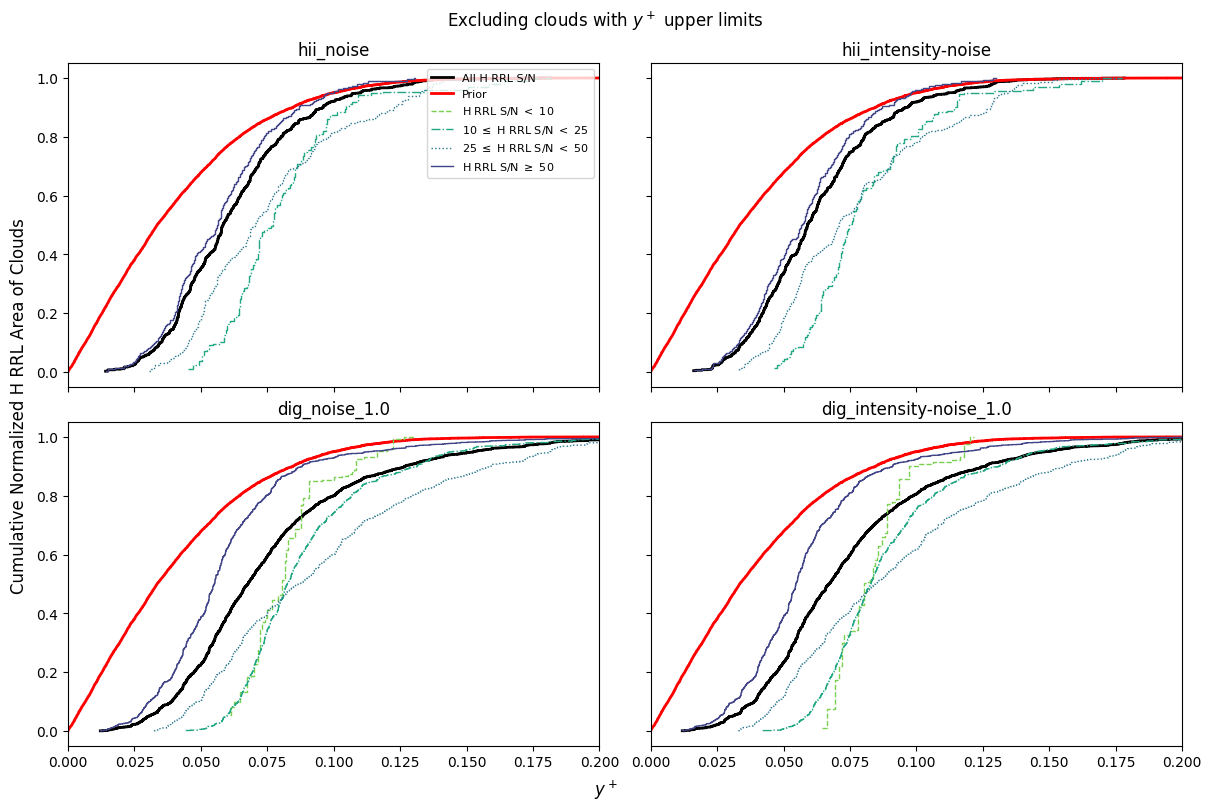

In [57]:
colors = cm.viridis(np.linspace(0.8, 0.2, len(snr_thresholds)))

fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for dataset, ax in zip(datasets, axes.ravel()):
  # plot CDF vs H_area
  mask = ~data[dataset]["cloud_results"]["is_limit"]
  sort_idx = data[dataset]["cloud_results"]["yplus_mean"].argsort()
  yplus_cdf = data[dataset]["cloud_results"].loc[sort_idx, "yplus_mean"].loc[mask]
  H_area_cdf = np.cumsum(
      data[dataset]["cloud_results"].loc[sort_idx, "H_amplitude_mean"].loc[mask] *
      data[dataset]["cloud_results"].loc[sort_idx, "H_fwhm_mean"].loc[mask]
  )
  H_area_cdf /= H_area_cdf.max()
  ax.step(
      yplus_cdf,
      H_area_cdf,
      where="mid",
      label="All H RRL S/N",
      linestyle="-",
      lw=2,
      color="k",
  )

  # plot prior
  ax.step(
      yplus_prior_cdf,
      H_area_prior_cdf,
      where="mid",
      label="Prior",
      linestyle="-",
      lw=2,
      color="r",
  )

  # breakdown by SNR threshold
  cycle_linestyles = cycle(linestyles)
  for (snr, limits), color in zip(snr_thresholds.items(), colors):
    mask = (data[dataset]["cloud_results"]["H SNR"] >= limits[0]) & (
        data[dataset]["cloud_results"]["H SNR"] < limits[1]
    ) & ~data[dataset]["cloud_results"]["is_limit"]
    if limits[0] == 0:
      label = r"H RRL S/N $<$ "+f"{int(limits[1])}"
    elif np.isinf(limits[1]):
      label = r"H RRL S/N $\geq$ "+f"{int(limits[0])}"
    else:
      label = f"{int(limits[0])}"+r" $\leq$ H RRL S/N $<$ "+f"{int(limits[1])}"
    sort_idx = data[dataset]["cloud_results"]["yplus_mean"].argsort()
    yplus_cdf = data[dataset]["cloud_results"].loc[sort_idx, "yplus_mean"].loc[mask]
    H_area_cdf = np.cumsum(
        data[dataset]["cloud_results"].loc[sort_idx, "H_amplitude_mean"].loc[mask] *
        data[dataset]["cloud_results"].loc[sort_idx, "H_fwhm_mean"].loc[mask]
    )
    H_area_cdf /= H_area_cdf.max()
    ax.step(
        yplus_cdf,
        H_area_cdf,
        where="mid",
        label=label,
        linestyle=next(cycle_linestyles),
        lw=1,
        color=color,
    )
  ax.set_title(dataset)
axes[0, 0].legend(loc="upper right", fontsize=8)
axes[0, 0].set_xlim(0.0, 0.2)
axes[0, 0].set_ylim(-0.05, 1.05)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"$y^+$")
fig.supylabel("Cumulative Normalized H RRL Area of Clouds")

Text(0.02, 0.5, 'Cumulative Density of Clouds')

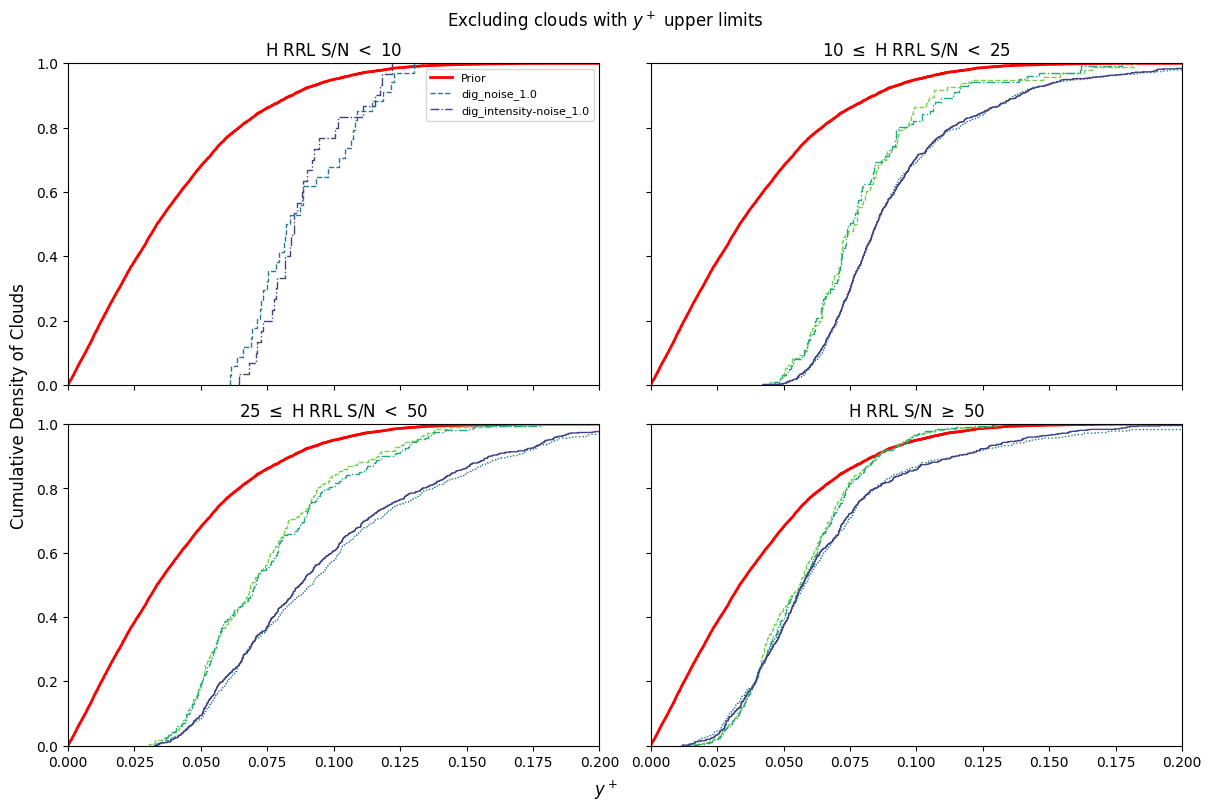

In [59]:
# break CDF down by SNR bin

colors = cm.viridis(np.linspace(0.8, 0.2, len(snr_thresholds)))

fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for (snr, limits), ax in zip(snr_thresholds.items(), axes.ravel()):
  if limits[0] == 0:
    label = r"H RRL S/N $<$ "+f"{int(limits[1])}"
  elif np.isinf(limits[1]):
    label = r"H RRL S/N $\geq$ "+f"{int(limits[0])}"
  else:
    label = f"{int(limits[0])}"+r" $\leq$ H RRL S/N $<$ "+f"{int(limits[1])}"
  ax.set_title(label)

  # plot prior
  ax.ecdf(yplus_prior_samples, label="Prior", linestyle="-", lw=2, color="r")

  # loop over datasets
  cycle_linestyles = cycle(linestyles)
  for dataset, color in zip(datasets, colors):
    mask = (data[dataset]["cloud_results"]["H SNR"] >= limits[0]) & (
        data[dataset]["cloud_results"]["H SNR"] < limits[1]
    ) & ~data[dataset]["cloud_results"]["is_limit"]
    if mask.sum() == 0:
      continue
    ax.ecdf(
        data[dataset]["cloud_results"].loc[mask, "yplus_mean"],
        label=dataset,
        linestyle=next(cycle_linestyles),
        lw=1,
        color=color,
    )
axes[0, 0].legend(loc="upper right", fontsize=8)
axes[0, 0].set_xlim(0.0, 0.2)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"$y^+$")
fig.supylabel("Cumulative Density of Clouds")

Text(0.02, 0.5, 'Cumulative Normalized H RRL Area of Clouds')

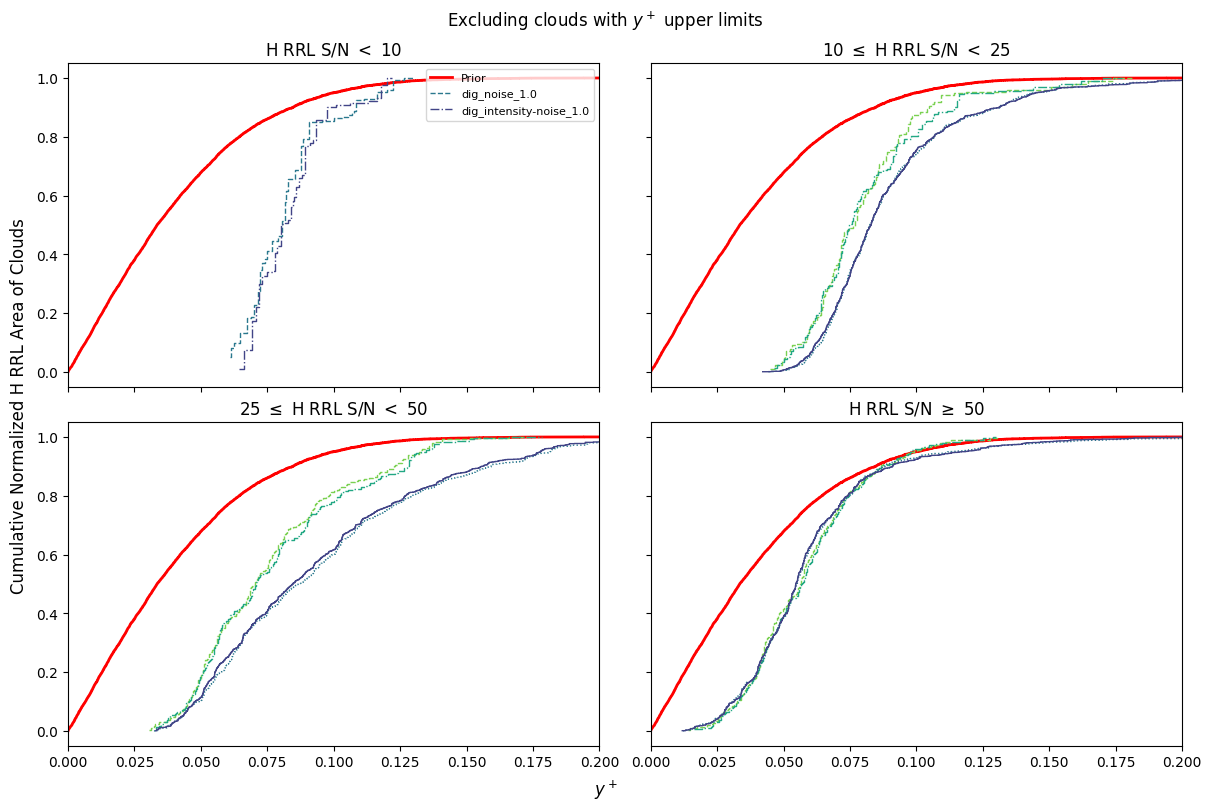

In [60]:
colors = cm.viridis(np.linspace(0.8, 0.2, len(snr_thresholds)))

fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for (snr, limits), ax in zip(snr_thresholds.items(), axes.ravel()):
  if limits[0] == 0:
    label = r"H RRL S/N $<$ "+f"{int(limits[1])}"
  elif np.isinf(limits[1]):
    label = r"H RRL S/N $\geq$ "+f"{int(limits[0])}"
  else:
    label = f"{int(limits[0])}"+r" $\leq$ H RRL S/N $<$ "+f"{int(limits[1])}"
  ax.set_title(label)

  # plot prior
  ax.step(
      yplus_prior_cdf,
      H_area_prior_cdf,
      where="mid",
      label="Prior",
      linestyle="-",
      lw=2,
      color="r",
  )

  # loop over datasets
  cycle_linestyles = cycle(linestyles)
  for dataset, color in zip(datasets, colors):
    mask = (data[dataset]["cloud_results"]["H SNR"] >= limits[0]) & (
        data[dataset]["cloud_results"]["H SNR"] < limits[1]
    ) & ~data[dataset]["cloud_results"]["is_limit"]
    if mask.sum() == 0:
      continue
    sort_idx = data[dataset]["cloud_results"]["yplus_mean"].argsort()
    yplus_cdf = data[dataset]["cloud_results"].loc[sort_idx, "yplus_mean"].loc[mask]
    H_area_cdf = np.cumsum(
        data[dataset]["cloud_results"].loc[sort_idx, "H_amplitude_mean"].loc[mask] *
        data[dataset]["cloud_results"].loc[sort_idx, "H_fwhm_mean"].loc[mask]
    )
    H_area_cdf /= H_area_cdf.max()
    ax.step(
        yplus_cdf,
        H_area_cdf,
        where="mid",
        label=dataset,
        linestyle=next(cycle_linestyles),
        lw=1,
        color=color,
    )
axes[0, 0].legend(loc="upper right", fontsize=8)
axes[0, 0].set_xlim(0.0, 0.2)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"$y^+$")
fig.supylabel("Cumulative Normalized H RRL Area of Clouds")

## y+ vs. Latitude

Text(0.02, 0.5, 'Number of Clouds')

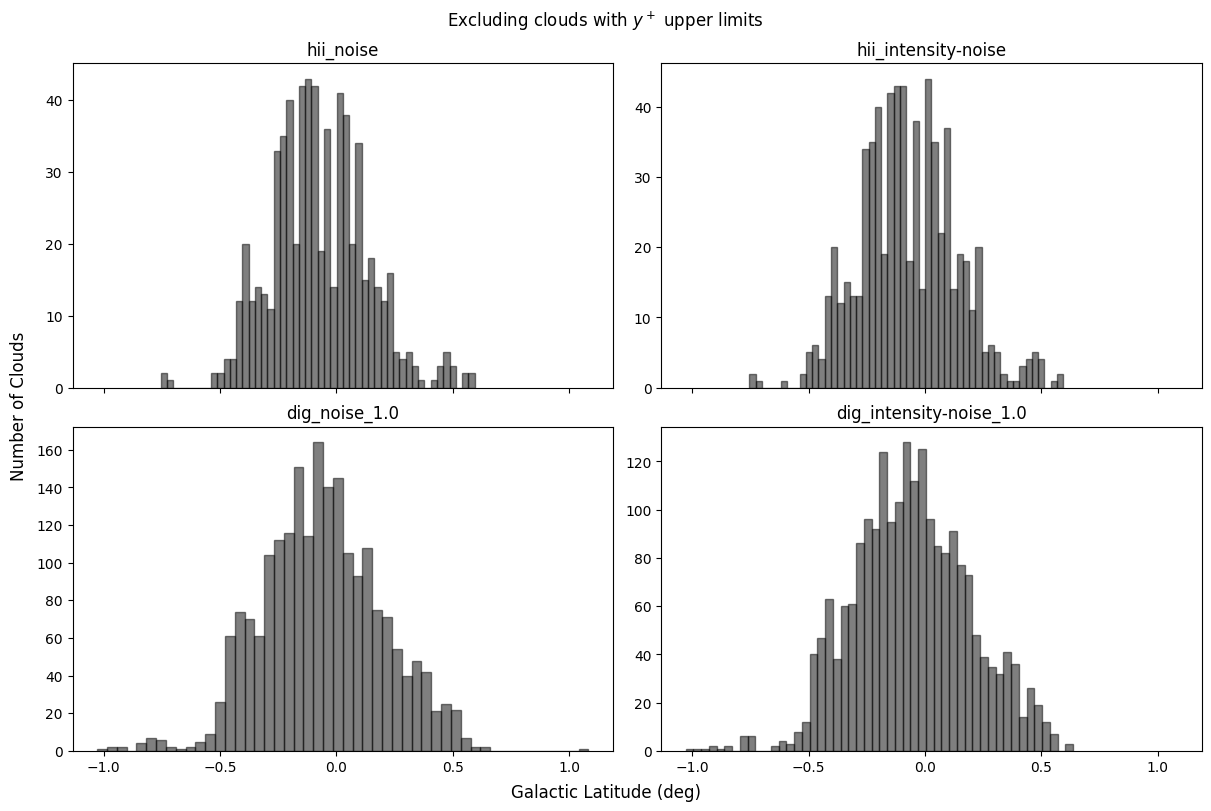

In [61]:
fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True)
for dataset, ax in zip(datasets, axes.ravel()):
  ax.hist(data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "glat"], bins=50, color="k", edgecolor="k", alpha=0.5)
  ax.set_title(dataset)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"Galactic Latitude (deg)")
fig.supylabel("Number of Clouds")

Text(0.02, 0.5, 'Density of Clouds')

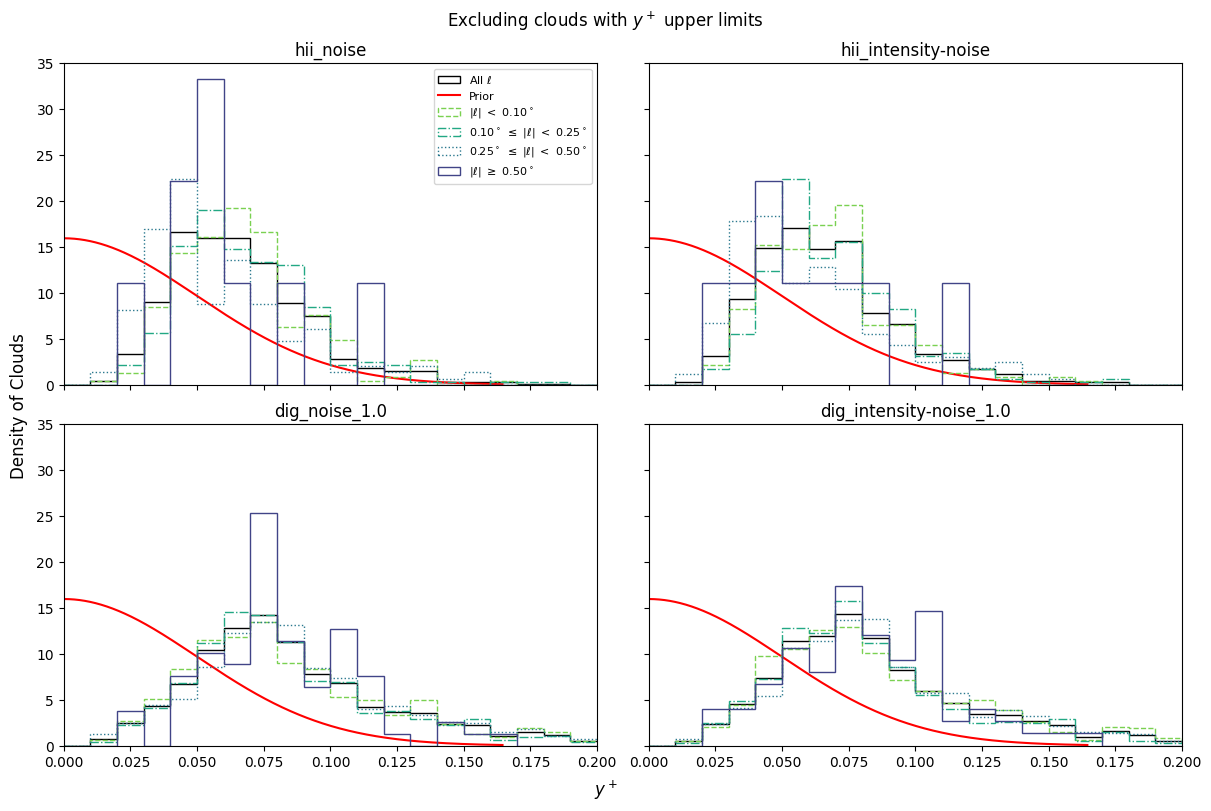

In [62]:
from itertools import cycle
linestyles = ["--", "-.", ":", "-"]

# histogram with latitude thresholds
glat_thresholds = {
    "midplane": [0.0, 0.1],
    "low_glat": [0.1, 0.25],
    "mid_glat": [0.25, 0.5],
    "high_glat": [0.5, np.inf],
}
colors = cm.viridis(np.linspace(0.8, 0.2, len(glat_thresholds)))

bins = np.arange(0.0, 0.31, 0.01)
fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for dataset, ax in zip(datasets, axes.ravel()):
  # plot PDF
  ax.hist(
      data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "yplus_mean"],
      bins=bins,
      label=r"All $\ell$",
      histtype="step",
      density=True,
      linestyle="-",
      lw=2,
      edgecolor="k",
  )

  # plot prior
  ax.plot(yplus_prior_x, yplus_prior_pdf, "r-", label="Prior")

  # breakdown by latitude threshold
  cycle_linestyles = cycle(linestyles)
  for (glat, limits), color in zip(glat_thresholds.items(), colors):
    mask = (~data[dataset]["cloud_results"]["is_limit"]) & (
        data[dataset]["cloud_results"]["glat"].abs() >= limits[0]) & (
        data[dataset]["cloud_results"]["glat"].abs() < limits[1]
    )
    if limits[0] == 0:
      label = r"$|\ell|$ $<$ "+f"{limits[1]:.2f}" + r"$^\circ$"
    elif np.isinf(limits[1]):
      label = r"$|\ell|$ $\geq$ "+f"{limits[0]:.2f}" + r"$^\circ$"
    else:
      label = f"{limits[0]:.2f}"+r"$^\circ$ $\leq$ $|\ell|$ $<$ "+f"{limits[1]:.2f}" + r"$^\circ$"
    ax.hist(
        data[dataset]["cloud_results"].loc[mask, "yplus_mean"],
        bins=bins,
        label=label,
        histtype="step",
        density=True,
        linestyle=next(cycle_linestyles),
        lw=1,
        color=color,
    )
  ax.set_title(dataset)
axes[0, 0].legend(loc="upper right", fontsize=8)
axes[0, 0].set_xlim(0.0, 0.2)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"$y^+$")
fig.supylabel("Density of Clouds")

Text(0.02, 0.5, 'Cumulative Density of Clouds')

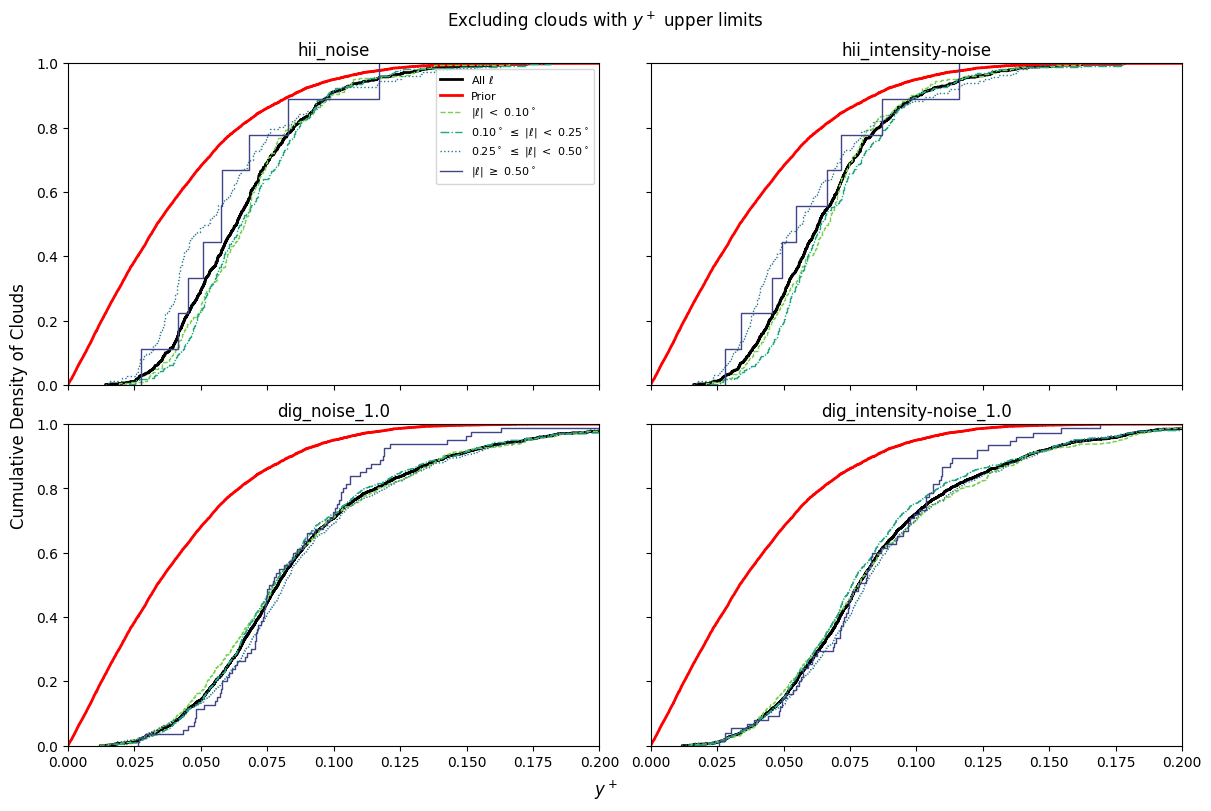

In [63]:
colors = cm.viridis(np.linspace(0.8, 0.2, len(snr_thresholds)))

fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for dataset, ax in zip(datasets, axes.ravel()):
  # plot CDF
  ax.ecdf(
      data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "yplus_mean"],
      label=r"All $\ell$",
      linestyle="-",
      lw=2,
      color="k",
  )

  # plot prior
  ax.ecdf(yplus_prior_samples, label="Prior", linestyle="-", lw=2, color="r")

  # breakdown by SNR threshold
  cycle_linestyles = cycle(linestyles)
  for (glat, limits), color in zip(glat_thresholds.items(), colors):
    mask = (~data[dataset]["cloud_results"]["is_limit"]) & (
        data[dataset]["cloud_results"]["glat"].abs() >= limits[0]) & (
        data[dataset]["cloud_results"]["glat"].abs() < limits[1]
    )
    if limits[0] == 0:
      label = r"$|\ell|$ $<$ "+f"{limits[1]:.2f}" + r"$^\circ$"
    elif np.isinf(limits[1]):
      label = r"$|\ell|$ $\geq$ "+f"{limits[0]:.2f}" + r"$^\circ$"
    else:
      label = f"{limits[0]:.2f}"+r"$^\circ$ $\leq$ $|\ell|$ $<$ "+f"{limits[1]:.2f}" + r"$^\circ$"
    ax.ecdf(
        data[dataset]["cloud_results"].loc[mask, "yplus_mean"],
        label=label,
        linestyle=next(cycle_linestyles),
        lw=1,
        color=color,
    )
  ax.set_title(dataset)
axes[0, 0].legend(loc="upper right", fontsize=8)
axes[0, 0].set_xlim(0.0, 0.2)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"$y^+$")
fig.supylabel("Cumulative Density of Clouds")

Text(0.02, 0.5, 'Cumulative Normalized H RRL Area of Clouds')

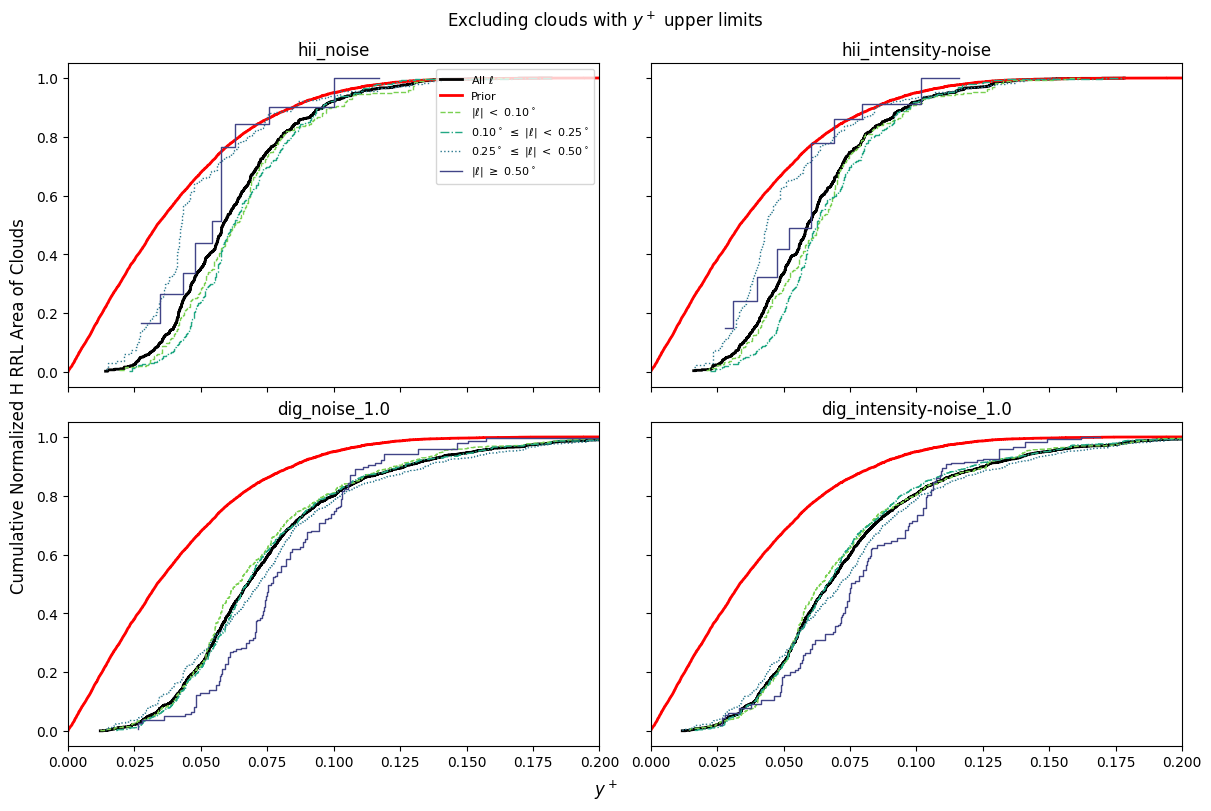

In [64]:
colors = cm.viridis(np.linspace(0.8, 0.2, len(snr_thresholds)))

fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for dataset, ax in zip(datasets, axes.ravel()):
  # plot CDF vs H_area
  sort_idx = data[dataset]["cloud_results"]["yplus_mean"].argsort()
  mask = (~data[dataset]["cloud_results"]["is_limit"])
  yplus_cdf = data[dataset]["cloud_results"].loc[sort_idx, "yplus_mean"].loc[mask]
  H_area_cdf = np.cumsum(
      data[dataset]["cloud_results"].loc[sort_idx, "H_amplitude_mean"].loc[mask] *
      data[dataset]["cloud_results"].loc[sort_idx, "H_fwhm_mean"].loc[mask]
  )
  H_area_cdf /= H_area_cdf.max()
  ax.step(
      yplus_cdf,
      H_area_cdf,
      where="mid",
      label=r"All $\ell$",
      linestyle="-",
      lw=2,
      color="k",
  )

  # plot prior
  ax.step(
      yplus_prior_cdf,
      H_area_prior_cdf,
      where="mid",
      label="Prior",
      linestyle="-",
      lw=2,
      color="r",
  )

  # breakdown by SNR threshold
  cycle_linestyles = cycle(linestyles)
  for (glat, limits), color in zip(glat_thresholds.items(), colors):
    mask = (~data[dataset]["cloud_results"]["is_limit"]) & (
        data[dataset]["cloud_results"]["glat"].abs() >= limits[0]) & (
        data[dataset]["cloud_results"]["glat"].abs() < limits[1]
    )
    if limits[0] == 0:
      label = r"$|\ell|$ $<$ "+f"{limits[1]:.2f}" + r"$^\circ$"
    elif np.isinf(limits[1]):
      label = r"$|\ell|$ $\geq$ "+f"{limits[0]:.2f}" + r"$^\circ$"
    else:
      label = f"{limits[0]:.2f}"+r"$^\circ$ $\leq$ $|\ell|$ $<$ "+f"{limits[1]:.2f}" + r"$^\circ$"
    sort_idx = data[dataset]["cloud_results"]["yplus_mean"].argsort()
    yplus_cdf = data[dataset]["cloud_results"].loc[sort_idx, "yplus_mean"].loc[mask]
    H_area_cdf = np.cumsum(
        data[dataset]["cloud_results"].loc[sort_idx, "H_amplitude_mean"].loc[mask] *
        data[dataset]["cloud_results"].loc[sort_idx, "H_fwhm_mean"].loc[mask]
    )
    H_area_cdf /= H_area_cdf.max()
    ax.step(
        yplus_cdf,
        H_area_cdf,
        where="mid",
        label=label,
        linestyle=next(cycle_linestyles),
        lw=1,
        color=color,
    )
  ax.set_title(dataset)
axes[0, 0].legend(loc="upper right", fontsize=8)
axes[0, 0].set_xlim(0.0, 0.2)
axes[0, 0].set_ylim(-0.05, 1.05)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"$y^+$")
fig.supylabel("Cumulative Normalized H RRL Area of Clouds")

Text(0.02, 0.5, 'Cumulative Density of Clouds')

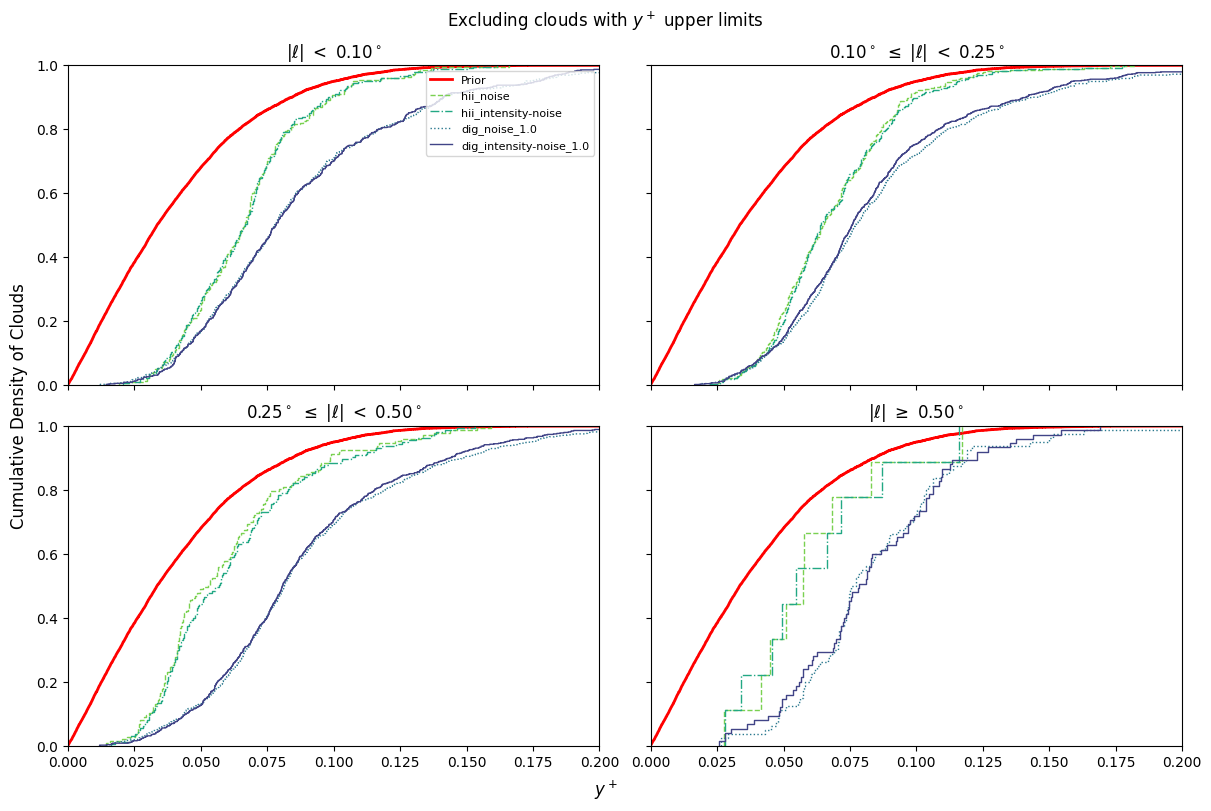

In [65]:
colors = cm.viridis(np.linspace(0.8, 0.2, len(snr_thresholds)))

fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for (glat, limits), ax in zip(glat_thresholds.items(), axes.ravel()):
  if limits[0] == 0:
    label = r"$|\ell|$ $<$ "+f"{limits[1]:.2f}" + r"$^\circ$"
  elif np.isinf(limits[1]):
    label = r"$|\ell|$ $\geq$ "+f"{limits[0]:.2f}" + r"$^\circ$"
  else:
    label = f"{limits[0]:.2f}"+r"$^\circ$ $\leq$ $|\ell|$ $<$ "+f"{limits[1]:.2f}" + r"$^\circ$"
  ax.set_title(label)

  # plot prior
  ax.ecdf(yplus_prior_samples, label="Prior", linestyle="-", lw=2, color="r")

  # breakdown by SNR threshold
  cycle_linestyles = cycle(linestyles)
  for dataset, color in zip(datasets, colors):
    mask = (~data[dataset]["cloud_results"]["is_limit"]) & (
        data[dataset]["cloud_results"]["glat"].abs() >= limits[0]) & (
        data[dataset]["cloud_results"]["glat"].abs() < limits[1]
    )

    ax.ecdf(
        data[dataset]["cloud_results"].loc[mask, "yplus_mean"],
        label=dataset,
        linestyle=next(cycle_linestyles),
        lw=1,
        color=color,
    )
axes[0, 0].legend(loc="upper right", fontsize=8)
axes[0, 0].set_xlim(0.0, 0.2)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"$y^+$")
fig.supylabel("Cumulative Density of Clouds")

## y+ vs. HII region separation

In [66]:
# calculate separation between each DIG spectrum and each HII region spectrum
from astropy.coordinates import SkyCoord

hii_coord = SkyCoord(l=data["hii_noise"]["cloud_results"]["glong"], b=data["hii_noise"]["cloud_results"]["glat"], frame="galactic", unit="deg")

dig_noise_coord = SkyCoord(l=data["dig_noise_1.0"]["cloud_results"]["glong"], b=data["dig_noise_1.0"]["cloud_results"]["glat"], frame="galactic", unit="deg")
dig_int_noise_coord = SkyCoord(l=data["dig_intensity-noise_1.0"]["cloud_results"]["glong"], b=data["dig_intensity-noise_1.0"]["cloud_results"]["glat"], frame="galactic", unit="deg")

data["dig_noise_1.0"]["cloud_results"]["hii_sep"] = [
    coord.separation(hii_coord).min().to('arcsec').value
    for coord in dig_noise_coord
]
data["dig_intensity-noise_1.0"]["cloud_results"]["hii_sep"] = [
    coord.separation(hii_coord).min().to('arcsec').value
    for coord in dig_int_noise_coord
]


Text(0.02, 0.5, 'Number of Clouds')

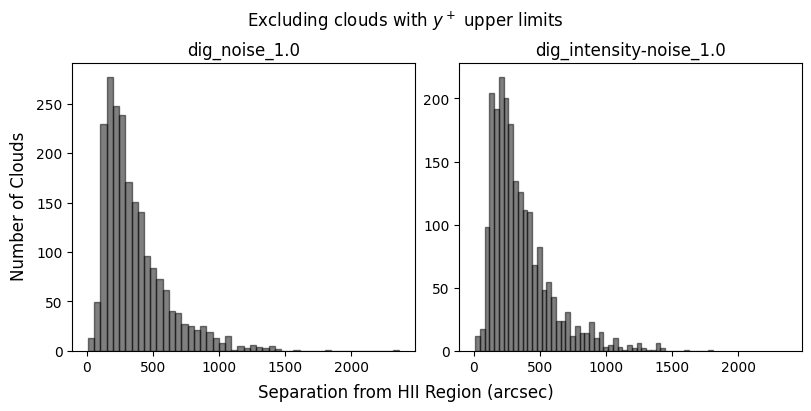

In [67]:
fig, axes = plt.subplots(1, 2, layout="constrained", figsize=(8, 4), sharex=True)
for dataset, ax in zip(datasets[2:], axes.ravel()):
  ax.hist(data[dataset]["cloud_results"]["hii_sep"].loc[~data[dataset]["cloud_results"]["is_limit"]], bins=50, color="k", edgecolor="k", alpha=0.5)
  ax.set_title(dataset)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"Separation from HII Region (arcsec)")
fig.supylabel("Number of Clouds")

Text(0.02, 0.5, 'Density of Clouds')

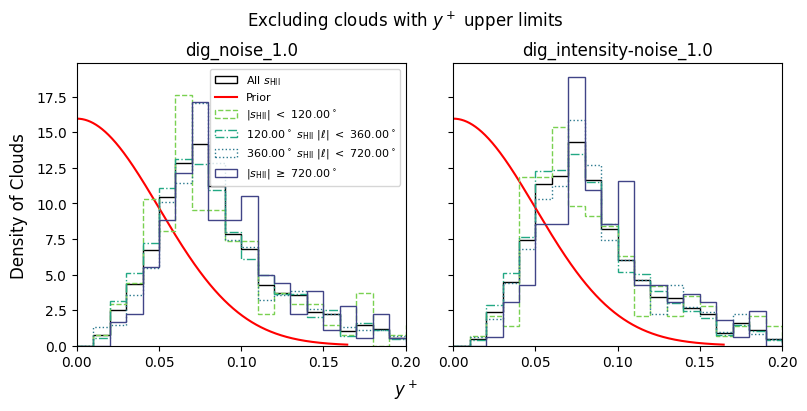

In [68]:
from itertools import cycle
linestyles = ["--", "-.", ":", "-"]

# histogram with HII separation thresholds
hii_sep_thresholds = {
    "close": [0.0, 120.0],
    "near": [120.0, 360.0],
    "mid": [360.0, 720.0],
    "far": [720.0, np.inf],
}
colors = cm.viridis(np.linspace(0.8, 0.2, len(hii_sep_thresholds)))

bins = np.arange(0.0, 0.31, 0.01)
fig, axes = plt.subplots(1, 2, layout="constrained", figsize=(8, 4), sharex=True, sharey=True)
for dataset, ax in zip(datasets[2:], axes.ravel()):
  # plot PDF
  ax.hist(
      data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "yplus_mean"],
      bins=bins,
      label=r"All $s_{\rm HII}$",
      histtype="step",
      density=True,
      linestyle="-",
      lw=2,
      edgecolor="k",
  )

  # plot prior
  ax.plot(yplus_prior_x, yplus_prior_pdf, "r-", label="Prior")

  # breakdown by latitude threshold
  cycle_linestyles = cycle(linestyles)
  for (hii_sep, limits), color in zip(hii_sep_thresholds.items(), colors):
    mask = (~data[dataset]["cloud_results"]["is_limit"]) & (
        data[dataset]["cloud_results"]["hii_sep"].abs() >= limits[0]) & (
        data[dataset]["cloud_results"]["hii_sep"].abs() < limits[1]
    )
    if limits[0] == 0:
      label = r"$|s_{\rm HII}|$ $<$ "+f"{limits[1]:.2f}" + r"$^\circ$"
    elif np.isinf(limits[1]):
      label = r"$|s_{\rm HII}|$ $\geq$ "+f"{limits[0]:.2f}" + r"$^\circ$"
    else:
      label = f"{limits[0]:.2f}"+r"$^\circ$ $s_{\rm HII}$ $|\ell|$ $<$ "+f"{limits[1]:.2f}" + r"$^\circ$"
    ax.hist(
        data[dataset]["cloud_results"].loc[mask, "yplus_mean"],
        bins=bins,
        label=label,
        histtype="step",
        density=True,
        linestyle=next(cycle_linestyles),
        lw=1,
        color=color,
    )
  ax.set_title(dataset)
axes[0].legend(loc="upper right", fontsize=8)
axes[0].set_xlim(0.0, 0.2)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"$y^+$")
fig.supylabel("Density of Clouds")

Text(0.02, 0.5, 'Cumulative Density of Clouds')

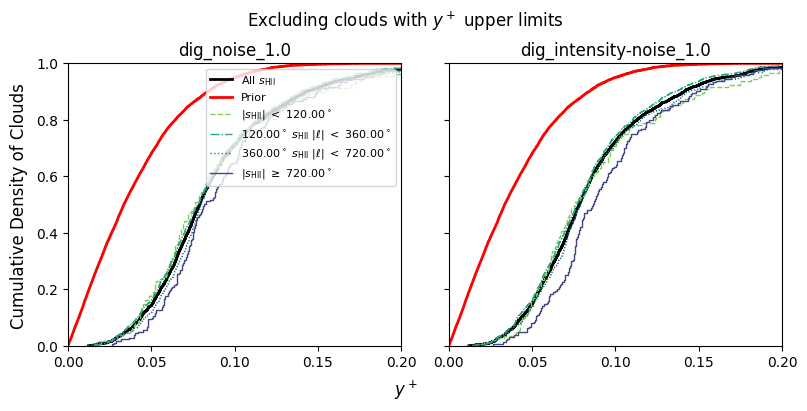

In [69]:
colors = cm.viridis(np.linspace(0.8, 0.2, len(snr_thresholds)))

fig, axes = plt.subplots(1, 2, layout="constrained", figsize=(8, 4), sharex=True, sharey=True)
for dataset, ax in zip(datasets[2:], axes.ravel()):
  # plot CDF
  ax.ecdf(
      data[dataset]["cloud_results"].loc[~data[dataset]["cloud_results"]["is_limit"], "yplus_mean"],
      label=r"All $s_{\rm HII}$",
      linestyle="-",
      lw=2,
      color="k",
  )

  # plot prior
  ax.ecdf(yplus_prior_samples, label="Prior", linestyle="-", lw=2, color="r")

  # breakdown by SNR threshold
  cycle_linestyles = cycle(linestyles)
  for (hii_sep, limits), color in zip(hii_sep_thresholds.items(), colors):
    mask = (~data[dataset]["cloud_results"]["is_limit"]) & (
        data[dataset]["cloud_results"]["hii_sep"].abs() >= limits[0]) & (
        data[dataset]["cloud_results"]["hii_sep"].abs() < limits[1]
    )
    if limits[0] == 0:
      label = r"$|s_{\rm HII}|$ $<$ "+f"{limits[1]:.2f}" + r"$^\circ$"
    elif np.isinf(limits[1]):
      label = r"$|s_{\rm HII}|$ $\geq$ "+f"{limits[0]:.2f}" + r"$^\circ$"
    else:
      label = f"{limits[0]:.2f}"+r"$^\circ$ $s_{\rm HII}$ $|\ell|$ $<$ "+f"{limits[1]:.2f}" + r"$^\circ$"
    ax.ecdf(
        data[dataset]["cloud_results"].loc[mask, "yplus_mean"],
        label=label,
        linestyle=next(cycle_linestyles),
        lw=1,
        color=color,
    )
  ax.set_title(dataset)
axes[0].legend(loc="upper right", fontsize=8)
axes[0].set_xlim(0.0, 0.2)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"$y^+$")
fig.supylabel("Cumulative Density of Clouds")

Text(0.02, 0.5, 'Cumulative Density of Clouds')

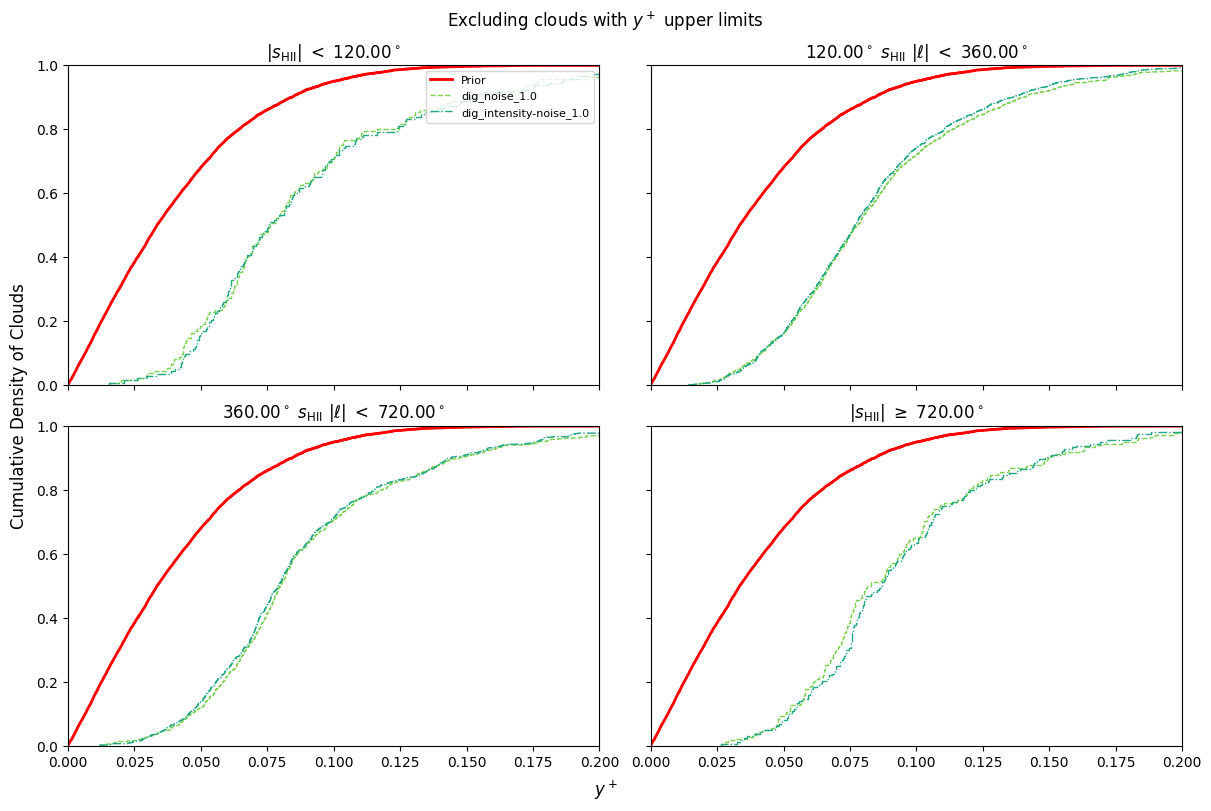

In [74]:
colors = cm.viridis(np.linspace(0.8, 0.2, len(snr_thresholds)))

fig, axes = plt.subplots(2, 2, layout="constrained", figsize=(12, 8), sharex=True, sharey=True)
for (hii_sep, limits), ax in zip(hii_sep_thresholds.items(), axes.ravel()):
  if limits[0] == 0:
    label = r"$|s_{\rm HII}|$ $<$ "+f"{limits[1]:.2f}" + r"$^\circ$"
  elif np.isinf(limits[1]):
    label = r"$|s_{\rm HII}|$ $\geq$ "+f"{limits[0]:.2f}" + r"$^\circ$"
  else:
    label = f"{limits[0]:.2f}"+r"$^\circ$ $s_{\rm HII}$ $|\ell|$ $<$ "+f"{limits[1]:.2f}" + r"$^\circ$"
  ax.set_title(label)

  # plot prior
  ax.ecdf(yplus_prior_samples, label="Prior", linestyle="-", lw=2, color="r")

  # breakdown by SNR threshold
  cycle_linestyles = cycle(linestyles)
  for dataset, color in zip(datasets[2:], colors):
    mask = (~data[dataset]["cloud_results"]["is_limit"]) & (
        data[dataset]["cloud_results"]["hii_sep"].abs() >= limits[0]) & (
        data[dataset]["cloud_results"]["hii_sep"].abs() < limits[1]
    )

    ax.ecdf(
        data[dataset]["cloud_results"].loc[mask, "yplus_mean"],
        label=dataset,
        linestyle=next(cycle_linestyles),
        lw=1,
        color=color,
    )
axes[0, 0].legend(loc="upper right", fontsize=8)
axes[0, 0].set_xlim(0.0, 0.2)
fig.suptitle(r"Excluding clouds with $y^+$ upper limits")
fig.supxlabel(r"$y^+$")
fig.supylabel("Cumulative Density of Clouds")